*Antonio Coín Castro*     


# Bayesian RKHS-based Functional Linear Regression

In [1]:
# -- Libraries

import os
import pickle
import sys

import arviz as az
import numpy as np
import pandas as pd
import skfda

import plot_utils
import rkbfr.bayesian_model as bayesian_model
import rkbfr.preprocessing as preprocessing
import rkbfr.simulation as simulation
import run_utils

from IPython.display import display
from matplotlib import pyplot as plt
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.smoothing.kernel_smoothers import \
    NadarayaWatsonSmoother as NW
from skfda.representation.basis import BSpline, Fourier
from skfda.representation.grid import FDataGrid
from sklearn.model_selection import KFold, train_test_split

from reference_methods._fpls import FPLSBasis
from rkbfr.mle import compute_mle
from rkbfr.utils import pp_to_idata

In [2]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)
pd.set_option("styler.format.precision", 3)

# Multiprocessing
N_CORES = 4

# Ignore warnings
np.seterr(over='ignore', divide='ignore')
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

We consider the model

$$
Y = \alpha_0 + \Psi^{-1}_{X}(\alpha) + \varepsilon,
$$

i.e.,

$$
Y_i\mid X_i=x_i \sim \mathcal N\left(\alpha_0 + \sum_{j=1}^p \beta_jx_i(\tau_j), \ \sigma^2\right).
$$

The prior distributions we choose are:

\begin{align*}
  \pi(\alpha_0, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N\left(b_0, g\sigma^2\left[\mathcal X_\tau' \mathcal X_\tau + \eta \lambda_{\text{max}}(\mathcal X_\tau' \mathcal X_\tau)I\right]^{-1}\right),
\end{align*}

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\alpha_0, \log\sigma) \propto 1.
$$

Writing the parameter vector as $\theta = (\beta, \tau, \alpha_0, \log\sigma)$, the joint posterior probability is:

$$
\pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \frac{|G_\tau|^{1/2}}{\sigma^{p+n}} \exp\left\{ -\frac{1}{2\sigma^2} \left(\|Y- \alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right) \right\}.
$$

Hence, the log-posterior probability is:

$$
\log \pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \frac{1}{2}\log |G_\tau| - (p+n)\log \sigma -\frac{1}{2\sigma^2} \left(\|Y-\alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right).  
$$



The metrics considered for model evaluation will be:

- RMSE.
- $R^2$.

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim GP(0, K(s, t))$, a response variable given by either a $L^2$ model or a "simple" RKHS function, a value of $\alpha_0=5$ and a variance of $\sigma^2=0.5$. More precisely, we choose one of

$$
Y_i \sim \mathcal N\big(5 -5X_i(0.1) + 10X_i(0.8), \ 0.5\big)
$$

or

$$
Y_i \sim \mathcal N\left(5 + \int_0^1 \beta(t)X_i(t)\, dt, \ 0.5\right),
$$

where $\beta \in L^2[0, 1]$.

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation.

In [3]:
# -- Data generation parameters

SYNTHETIC_DATA = True
REGRESSOR_GEN = "GP"  # 'GP' or 'GBM'
MODEL_GEN = "RKHS"  # 'L2' or 'RKHS'
REAL_DATA = "Tecator"

INITIAL_SMOOTHING = None  # None, 'NW' or 'Basis'
N_BASIS = 16
SCALE_PREDICTORS = False
STANDARDIZE_RESPONSE = False

n_train, n_test = 100, 50
N = 100
tau_range = (0, 1)

mean_vector = np.zeros(N)
kernel_fn = simulation.fractional_brownian_kernel
smoothing_params = np.logspace(-4, 4, 50)

In [4]:
# -- Dataset generation

if SYNTHETIC_DATA:
    grid = np.linspace(tau_range[0] + 1./N, tau_range[1], N)
    alpha0_true = 5.
    sigma2_true = 0.5
    
    # Generate X
    if REGRESSOR_GEN == "GP":
        x = simulation.gp(
            grid, 
            mean_vector, 
            kernel_fn, 
            n_train + n_test, 
            rng
        )
    else:  # GBM
        x = np.exp(
            simulation.gp(
                grid, 
                mean_vector, 
                simulation.brownian_kernel,
                n_train + n_test, 
                rng
            ))

    # Generate Y
    if MODEL_GEN == "L2":
        beta_coef = simulation.cholaquidis_scenario3
        y = simulation.generate_l2_dataset(
            x,
            grid,
            beta_coef,
            alpha0_true,
            sigma2_true,
            rng=rng
        )
    elif MODEL_GEN == "RKHS":
        beta_true = [-5., 10.]
        tau_true = [0.1, 0.8]
        y = simulation.generate_rkhs_dataset(
            x,
            grid,
            beta_true,
            tau_true,
            alpha0_true,
            sigma2_true,
            rng=rng
        )
    else:
        raise ValueError("Invalid model generation strategy.")

    # Train/test split
    X, X_test, Y, Y_test = train_test_split(
        x, y, train_size=n_train, random_state=SEED)

    # Create FData object
    X_fd = skfda.FDataGrid(X, grid)
    X_test_fd = skfda.FDataGrid(X_test, grid)

else:  # Real data
    if REAL_DATA == "Tecator":
        x, y = skfda.datasets.fetch_tecator(return_X_y=True)
        data = x.data_matrix[..., 0]
        u, idx = np.unique(data, axis=0, return_index=True)
        x = FDataGrid(data[idx], x.grid_points[0]).derivative(order=2)
        y = y[idx, 1]  # Fat level
    elif REAL_DATA == "Moisture":
        data = skfda.datasets.fetch_cran(
            "Moisturespectrum", "fds")["Moisturespectrum"]
        y = skfda.datasets.fetch_cran(
            "Moisturevalues", "fds")["Moisturevalues"]
        x = FDataGrid(data["y"].T[:, ::7], data["x"][::7])
    elif REAL_DATA == "Sugar":
        data = np.load('data/sugar.npz')
        x = FDataGrid(data['x'][:, ::5])
        y = data['y']
    else:
        raise ValueError("REAL_DATA must be 'Tecator' or 'Aemet'.")

    N = len(x.grid_points[0])
    grid = preprocessing.normalize_grid(
        x.grid_points[0], tau_range[0], tau_range[1])
    
    x = FDataGrid(x.data_matrix, grid)

    X_fd, X_test_fd, Y, Y_test = train_test_split(
        x, y, train_size=0.667, random_state=SEED)

    n_train, n_test = len(X_fd.data_matrix), len(X_test_fd.data_matrix)

# Smooth data

if INITIAL_SMOOTHING is not None:
    if INITIAL_SMOOTHING == "NW":
        smoother = NW()
    elif INITIAL_SMOOTHING == "Basis":
        basis = BSpline(n_basis=N_BASIS)
        smoother = BasisSmoother(basis)
    else:
        raise ValueError(
            f"Expected 'NW' or 'Basis' but got {INITIAL_SMOOTHING}.")

    X_fd, best_smoother, X_test_fd = preprocessing.smooth_data(
        X_fd,
        smoother,
        smoothing_params,
        X_test_fd
    )

    print(
        "Smoother: {}".format(
            best_smoother.best_estimator_.__class__.__name__))
    print(
        "Smoothing parameter: {:.3f}".format(
            best_smoother.best_params_['smoothing_parameter']))

# Standardize data
X_fd, X_test_fd = preprocessing.standardize_predictors(
    X_fd, X_test_fd, SCALE_PREDICTORS)

if STANDARDIZE_RESPONSE:
    Y, Y_test = preprocessing.standardize_response(Y, Y_test)

# Get data matrices

X = X_fd.data_matrix.reshape(-1, N)
X_test = X_test_fd.data_matrix.reshape(-1, N)

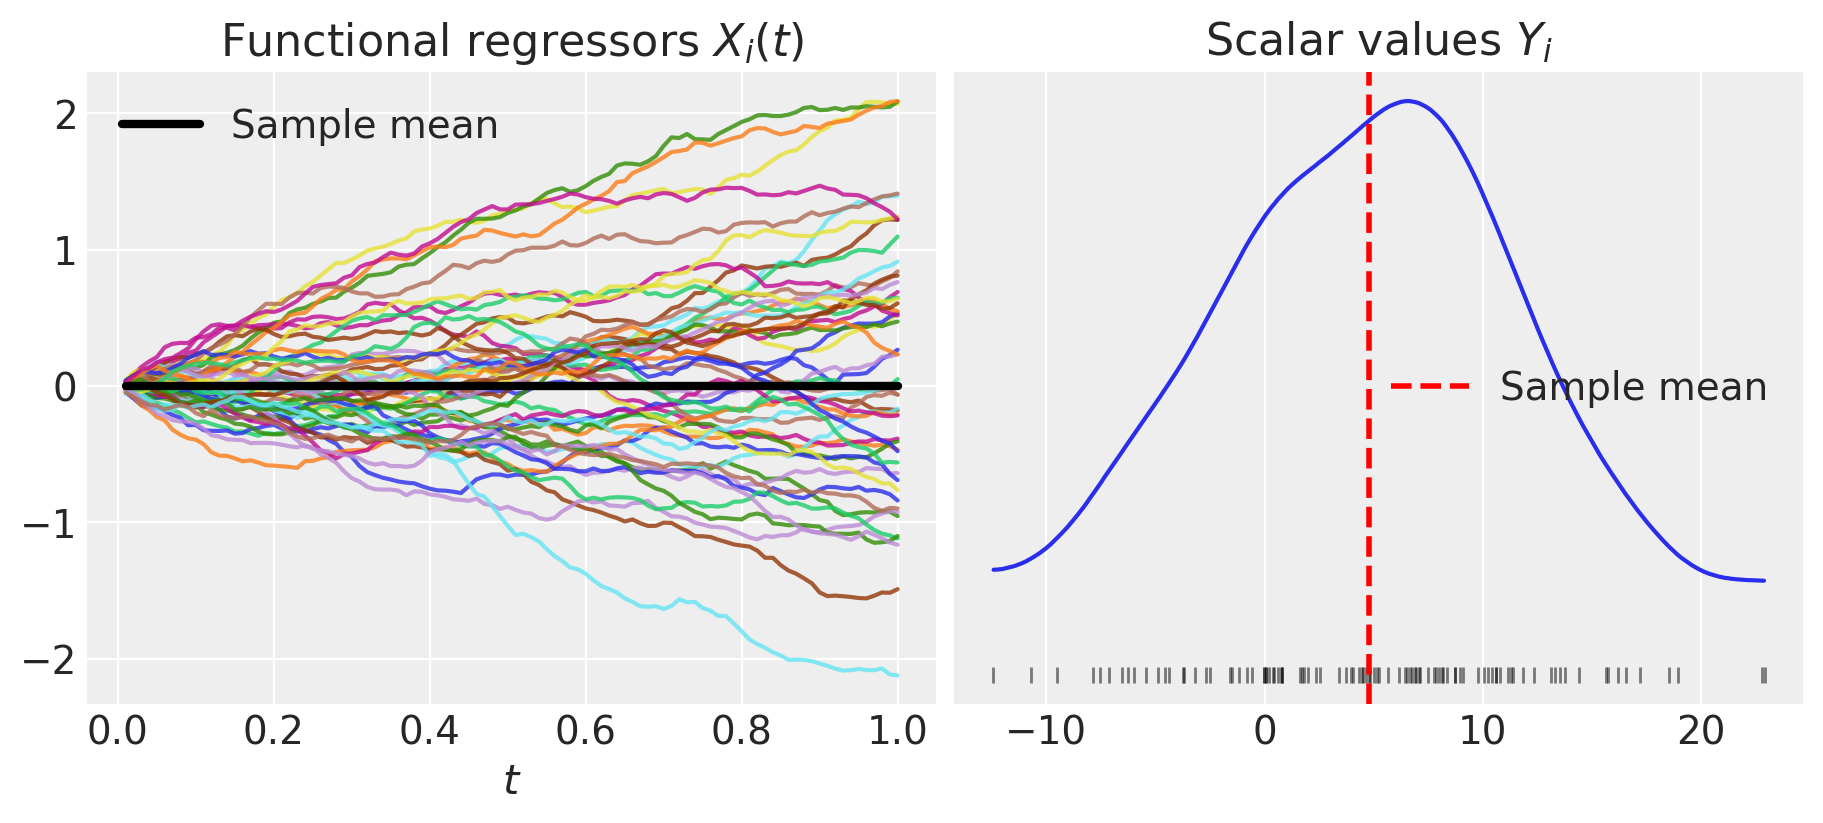

In [5]:
# -- Dataset visualization

plot_utils.plot_dataset_regression(
    X,
    Y,
    n_samples=n_train if not SYNTHETIC_DATA else n_train//2
)

## Common model hyperparameters

In our algorithms, we consider an unconstrained tranformed parameter space $\tilde \Theta=\mathbb{R}^{2\hat p+2}$ via the bijections

- $\tau_j \mapsto \operatorname{logit}(\tau_j)$.
- $\sigma^2 \mapsto \log\sigma$.

In [6]:
# -- Model hyperparameters

p_max = 3
g = 5
eta = 1e-2

mle_method = 'L-BFGS-B'  # 'Nelder-Mead', 'Powell' or 'L-BFGS-B'
mle_strategy = 'global'

prior_p = {
    1: 0.10,
    2: 0.60,
    3: 0.30,
}

beta_range = None
sigma2_ub = np.inf

INCLUDE_P = False
TRANSFORM_TAU = False
TRANSFORM_SIGMA = True
FIT_SK = True
COMPUTE_MLE = True

In [7]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
if INCLUDE_P:
    theta_names = ["p"] + theta_names

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]
if INCLUDE_P:
    theta_labels_grouped = [r"$p$"] + theta_labels_grouped

# Individual labels
theta_labels = [] if not INCLUDE_P else [theta_labels_grouped[0]]
for i in range(p_max):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_max):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
dim_name = "theta"
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={dim_name: dict(
        zip(np.arange(p_max), np.arange(1, p_max + 1)))}
)

In [8]:
# -- Parameter space and miscellaneous

if TRANSFORM_TAU:
    tau_ttr = bayesian_model.Logit()
else:
    tau_ttr = bayesian_model.Identity()

if TRANSFORM_SIGMA:
    sigma2_ttr = bayesian_model.LogSq()
else:
    sigma2_ttr = bayesian_model.Identity()

# Parameter space
theta_space = bayesian_model.ThetaSpace(
    p_max,
    grid,
    include_p=INCLUDE_P,
    names=theta_names,
    labels=theta_labels,
    labeller=theta_labeller,
    tau_range=tau_range,
    beta_range=beta_range,
    tau_ttr=tau_ttr,
    sigma2_ttr=sigma2_ttr,
    sigma2_ub=sigma2_ub
)

# Statistics for posterior predictive checks
point_estimators_bpv = [
    ("min", np.min),
    ("max", np.max),
    ("median", np.median),
    ("mean", np.mean),
    ("std", np.std)
]

# Folds for CV
folds = KFold(shuffle=True, random_state=SEED)

# Column to order results
sort_by = -2

## Sklearn model comparison

In [9]:
# -- Select family of regressors

alphas = np.logspace(-4, 4, 20)
n_selected = [5, 10, 15, 20, 25, 50]
n_components = [2, 3, 4, 5, 7, 10, 15, 20]
n_basis_bsplines = [8, 10, 12, 14, 16]
n_basis_fourier = [3, 5, 7, 9, 11]

basis_bspline = [BSpline(n_basis=p) for p in n_basis_bsplines]
basis_fourier = [Fourier(n_basis=p) for p in n_basis_fourier]

params_regularizer = {"reg__alpha": alphas}
params_select = {"selector__p": n_selected}
params_pls = {"reg__n_components": n_components}
params_dim_red = {"dim_red__n_components": n_components}
params_basis = {"basis__basis": basis_bspline + basis_fourier}

regressors = run_utils.linear_regression_comparison_suite(
    params_regularizer,
    params_select,
    params_dim_red,
    params_basis,
    params_pls,
    random_state=SEED
)

In [10]:
# -- Fit models and show metrics

if FIT_SK:
    df_metrics_sk, reg_cv = run_utils.cv_sk(
        regressors,
        X_fd,
        Y,
        X_test_fd,
        Y_test,
        folds,
        kind='linear',
        n_jobs=N_CORES,
        sort_by=sort_by,
        verbose=True
    )
    display(df_metrics_sk.style.hide(axis="index"))

  Fitting lasso...


 /home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.900e-01, tolerance: 5.415e-01


  Fitting ridge...
  Fitting pls1...
  Fitting manual+ridge...


 /home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning:The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).


  Fitting fpca+ridge...
  Fitting pca+ridge...
  Fitting pls+ridge...
  Fitting rmh+ridge...
  Fitting apls...
  Fitting flin...
  Fitting fpls1...


 /home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:
140 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/antcc/MCD/TFM/rk-bfr/reference_methods/_fpls.py", line 236, in fit
    rais

## Maximum Likelihood Estimator

In [11]:
# -- MLE computation

if COMPUTE_MLE:
    print(f"-- Computing MLE with {N_CORES} independent runs --")

    theta_space_fixed = theta_space.copy_p_fixed()

    mle_theta, bic = compute_mle(
        X,
        Y,
        theta_space_fixed,
        kind='linear',
        method=mle_method,
        strategy=mle_strategy,
        n_jobs=N_CORES,
        rng=rng
    )

    Y_pred_mle = bayesian_model.generate_response_linear(
        X_test, mle_theta, theta_space_fixed, noise=False
    )

    df_metrics_mle = run_utils.linear_regression_metrics(
        Y_test,
        Y_pred_mle,
        theta_space.p_max,
        "mle"
    )
    print(f"\nBIC [p={p_max}]: {bic:.3f}")
    display(pd.DataFrame(zip(theta_space_fixed.labels, mle_theta),
                         columns=["", "MLE"]).style.hide(axis="index"))
    print("Regression metrics:")
    display(df_metrics_mle.style.hide(axis="index"))

-- Computing MLE with 4 independent runs --

BIC [p=3]: 57.115


Regression metrics:


## The Ensemble Sampler and the *emcee* library

In [12]:
from rkbfr.mcmc_sampler import BFLinearEmcee
import emcee

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [13]:
# -- Sampler parameters

n_walkers = 32
n_iter_warmup = 100
n_iter = 700

compute_pp = False
compute_ll = False
frac_random = 0.3

moves = [
    (emcee.moves.StretchMove(), 0.7),
    (emcee.moves.WalkMove(), 0.3)
]

thin = 1
thin_pp = 5
burn = 200

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [14]:
# -- Run sampler

print("-- Running affine-invariant ensemble sampler "
      f"with {N_CORES} cores --")

reg_emcee = BFLinearEmcee(
    theta_space,
    n_walkers,
    n_iter,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    n_iter_warmup=n_iter_warmup,
    initial_state='mle',
    frac_random=frac_random,
    moves=moves,
    compute_pp=compute_pp,
    compute_ll=compute_ll,
    thin=thin,
    thin_pp=thin_pp,
    burn=burn,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    progress_notebook=True,
    random_state=rng,  # change to 'SEED' for the same output each time
)

if FAST_RUN:
    df_metrics_emcee = run_utils.run_bayesian_model(
        reg_emcee,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        kind='linear',
        prefix='emcee',
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        sort_by=sort_by,
        verbose=True,
        notebook=True,
        random_state=SEED,
    )
    if COMPUTE_METRICS_FAST_RUN:
        if COMPUTE_MLE:
            df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_mle])
        if FIT_SK:
            df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_sk])

        df_metrics_emcee.sort_values(
            df_metrics_emcee.columns[sort_by],
            inplace=True
        )
        display(df_metrics_emcee.style.hide(axis="index"))
else:
    reg_emcee.fit(X, Y)
    print(f"Mean acceptance: {100*reg_emcee.mean_acceptance():.3f}%")

idata_emcee = reg_emcee.get_idata()

-- Running affine-invariant ensemble sampler with 4 cores --
[BFLinearEmcee] Computing MLE...
[BFLinearEmcee] MCMC warmup iterations...


[BFLinearEmcee] MCMC:   0%|          | 0/700 [00:00<?, ?it/s]

[BFLinearEmcee] Discarding the first 200 samples...
Mean acceptance: 26.143%


mean     sd  hdi_3%  hdi_97%    min     max  median    mode
β[1]        -4.273  0.650  -5.330   -3.018 -8.322  -1.946  -4.247  -4.156
β[2]        -0.939  1.065  -1.999   -0.073 -5.035  11.594  -0.936  -0.764
β[3]        10.693  0.952  10.057   11.716 -1.535  13.854  10.694  10.804
τ[1]         0.092  0.013   0.075    0.111  0.011   0.280   0.093   0.092
τ[2]         0.585  0.082   0.424    0.740  0.203   0.803   0.594   0.580
τ[3]         0.795  0.024   0.787    0.805  0.624   0.960   0.799   0.800
$\alpha_0$   4.767  0.204   4.647    4.941  3.463   5.364   4.794   4.794
$\sigma^2$   0.849  2.319   0.317    0.595  0.268  22.594   0.430   0.420


Computing metrics...

Generating posterior predictive samples...


### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value. The effective sample size is computed as suggested [here (p.66)](https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/mcmc_slides.pdf). Missing values are replaced with a value of $0$.

In [15]:
# -- Sampler statistics and trace (with burn-in and thinning)

# Get number of samples
n_samples_emcee = reg_emcee.total_samples()

# Get autocorrelation times
autocorr = reg_emcee.autocorrelation_times()

pd.DataFrame(
    zip(theta_labels, autocorr, n_samples_emcee/autocorr),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide(axis="index")

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [39.966 37.918 31.932 37.076 38.638 40.625 39.709 37.753]


In [16]:
# -- Trace summary

reg_emcee.summary()

mean     sd  hdi_3%  hdi_97%    min     max  median    mode
β[1]        -4.273  0.650  -5.330   -3.018 -8.322  -1.946  -4.247  -4.156
β[2]        -0.939  1.065  -1.999   -0.073 -5.035  11.594  -0.936  -0.764
β[3]        10.693  0.952  10.057   11.716 -1.535  13.854  10.694  10.804
τ[1]         0.092  0.013   0.075    0.111  0.011   0.280   0.093   0.092
τ[2]         0.585  0.082   0.424    0.740  0.203   0.803   0.594   0.580
τ[3]         0.795  0.024   0.787    0.805  0.624   0.960   0.799   0.800
$\alpha_0$   4.767  0.204   4.647    4.941  3.463   5.364   4.794   4.794
$\sigma^2$   0.849  2.319   0.317    0.595  0.268  22.594   0.430   0.420

Combined density and trace plot:


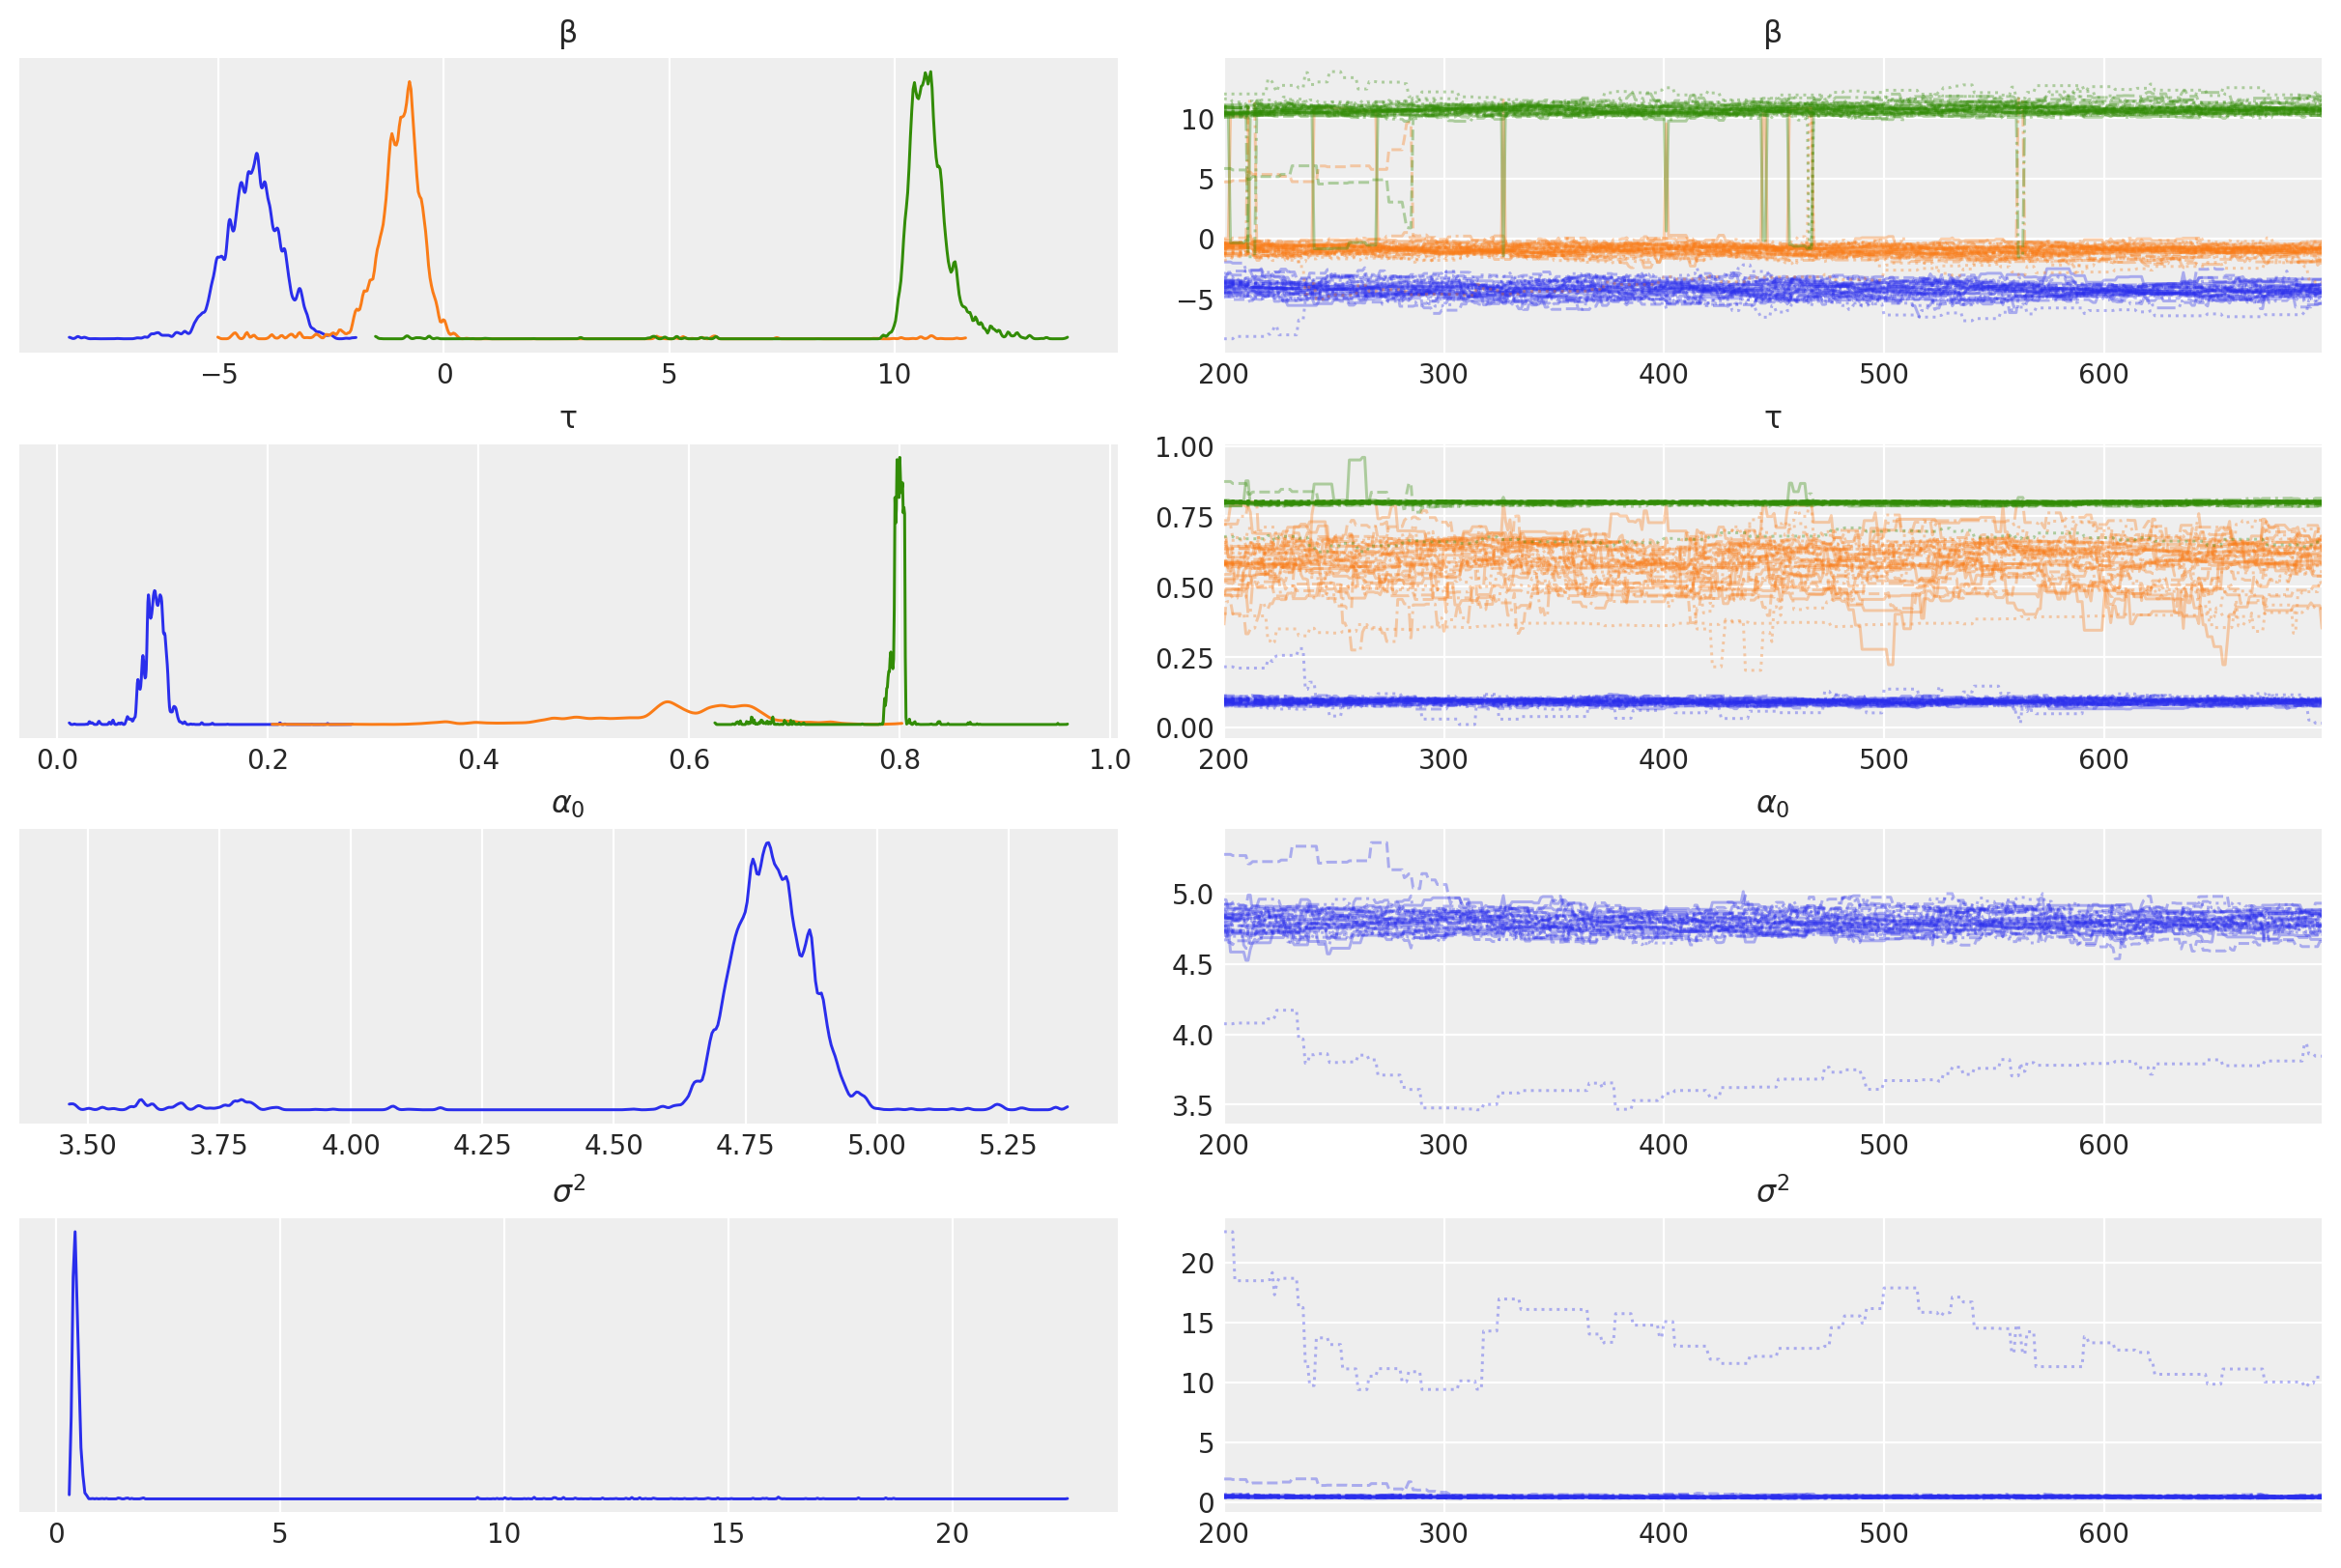

In [17]:
# -- Trace plot

az.plot_trace(
    idata_emcee,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)

print("Combined density and trace plot:")

Marginal posterior distributions:


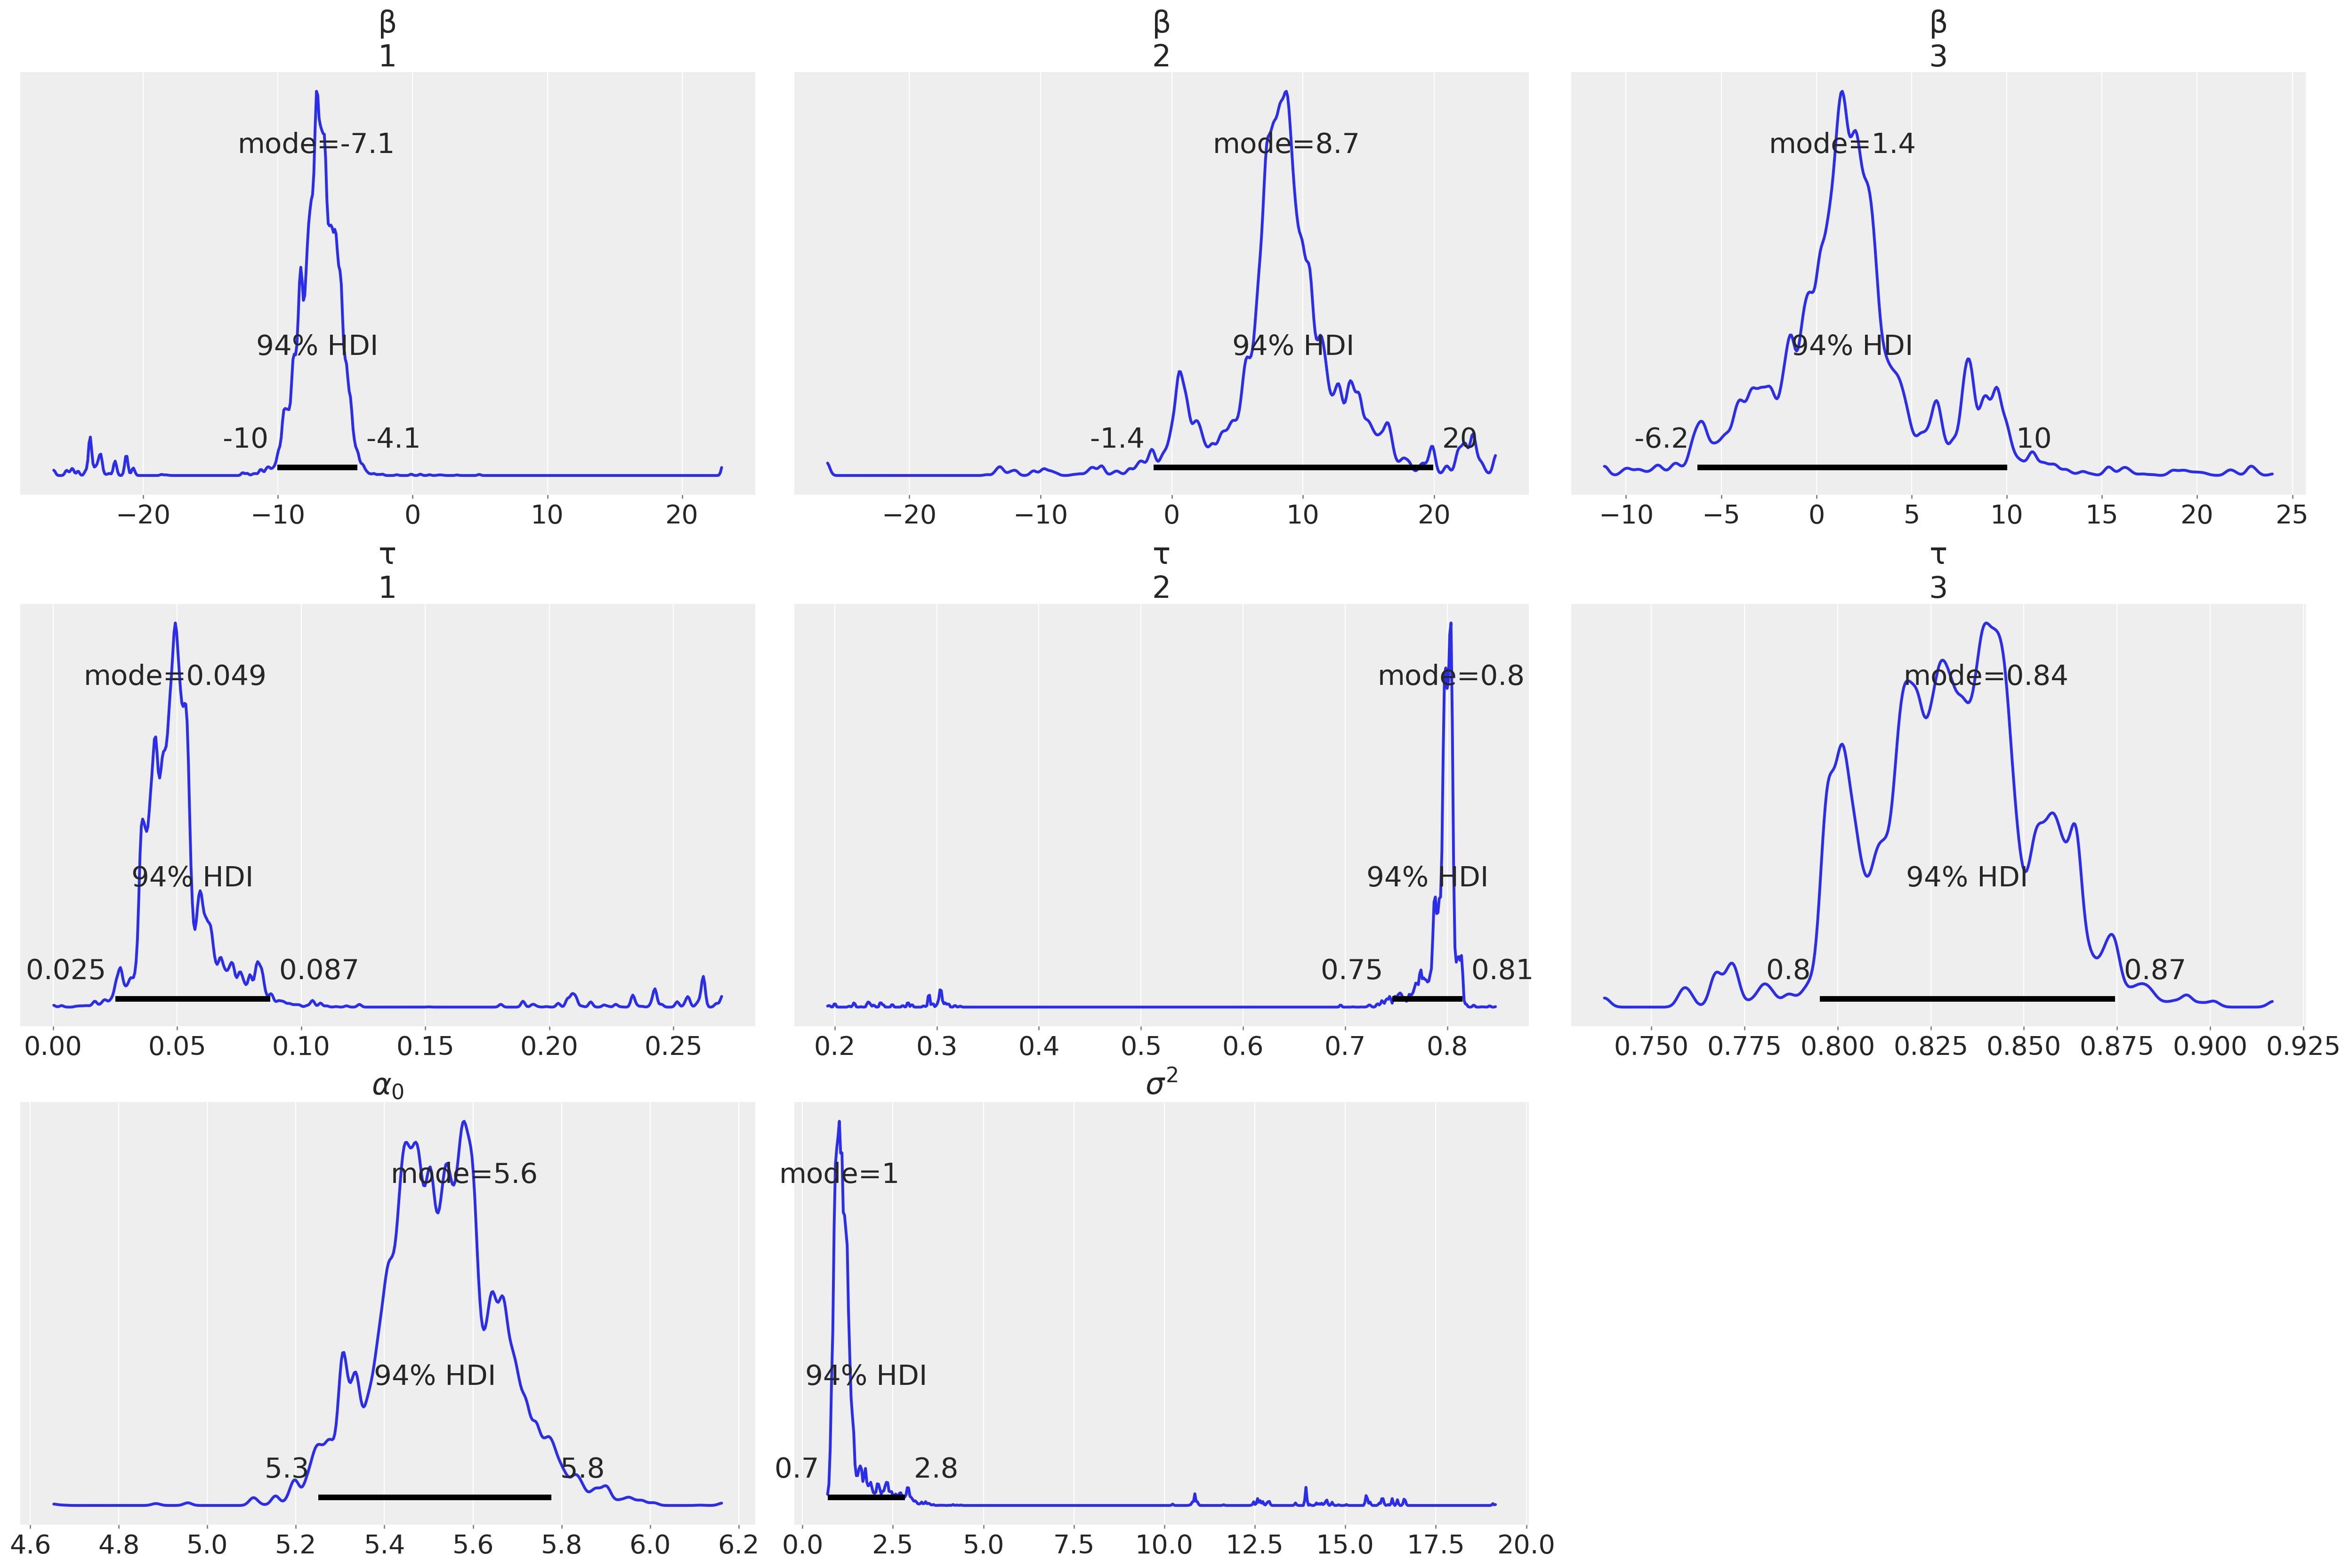

In [64]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

Forest plot of 94% HDI for β and τ:


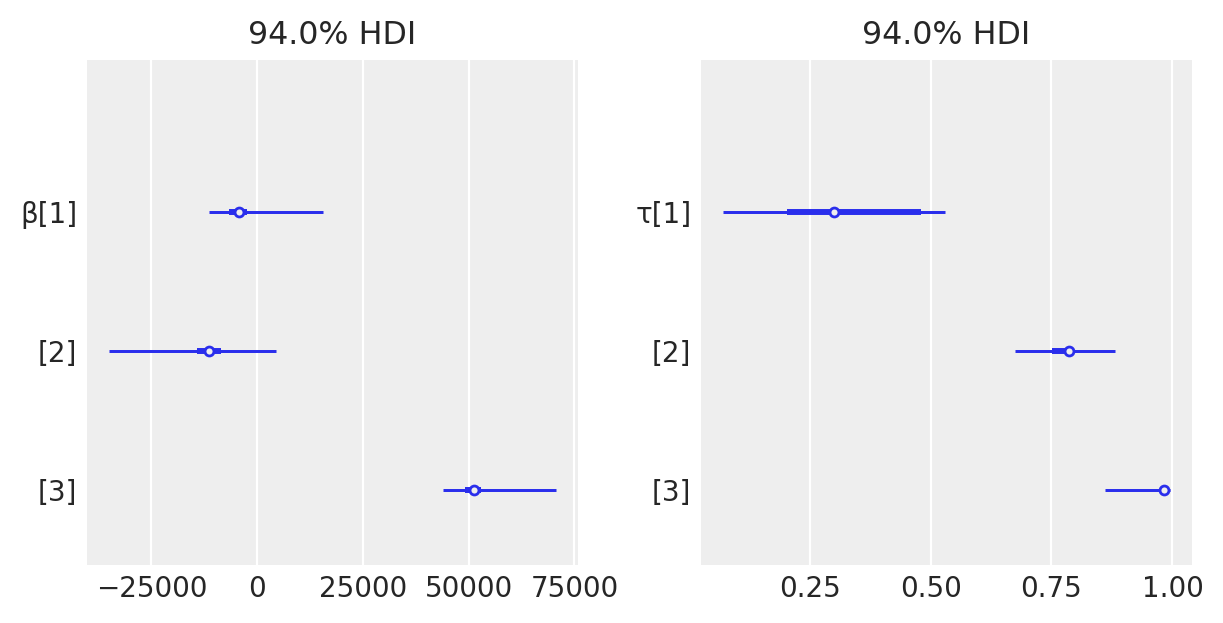

In [52]:
# -- Forest plot

plot_utils.plot_forest(
    idata_emcee, 
    theta_space, 
    textsize=10, 
    var_names=[theta_names[theta_space.beta_idx_grouped], 
               theta_names[theta_space.tau_idx_grouped]]
)

print("Forest plot of 94% HDI for β and τ:")

We can perform a couple of visual posterior predictive checks. In particular:
    
- A plot of the distribution of $Y$ and the distribution of $\{Y^*_m\}_m$ (one for every sample $\theta_m$ of the chain), generated using the original traning data $X$.
- A plot of the distribution of $T(Y^*)$, where $T(x)=\bar x$. 

We also show the Bayesian p-value for several statistics, which is defined as $P(T(y^*)\leq T(y)\mid y)$, and is computed by simply measuring the proportion of generated samples $\{T(Y^*_m)\}_m$ that fall below the real value of the statistic. It is expected to be around $0.5$ when the model accurately represents the data.

Generating posterior predictive samples...
bpv [T=min]: 0.497
bpv [T=max]: 0.128
bpv [T=median]: 0.207
bpv [T=mean]: 0.534
bpv [T=std]: 0.532


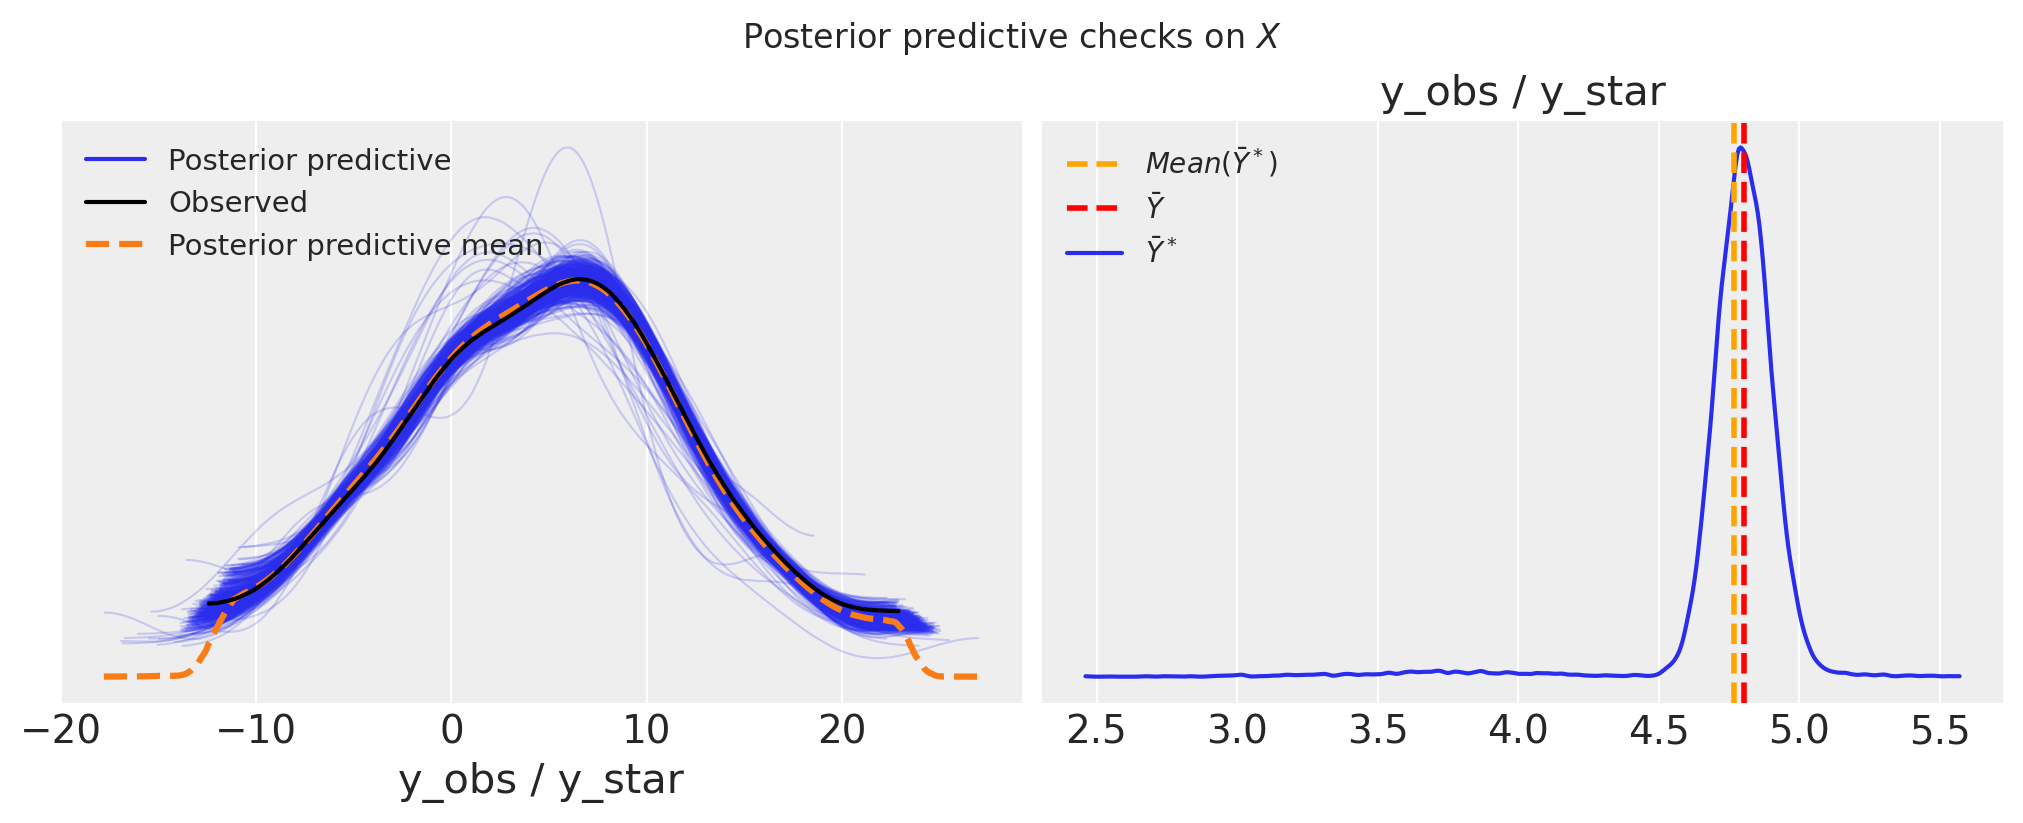

In [18]:
# -- Generate and plot posterior predictive checks from X

if "posterior_predictive" not in idata_emcee:
    pp = bayesian_model.generate_pp(
        idata_emcee, X, theta_space,
        rng=rng, kind='linear', verbose=True)
    pp_to_idata([pp], idata_emcee, ['y_star'], merge=True)
else:
    pp = idata_emcee.posterior_predictive['y_star'].to_numpy()

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_emcee, test=False)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


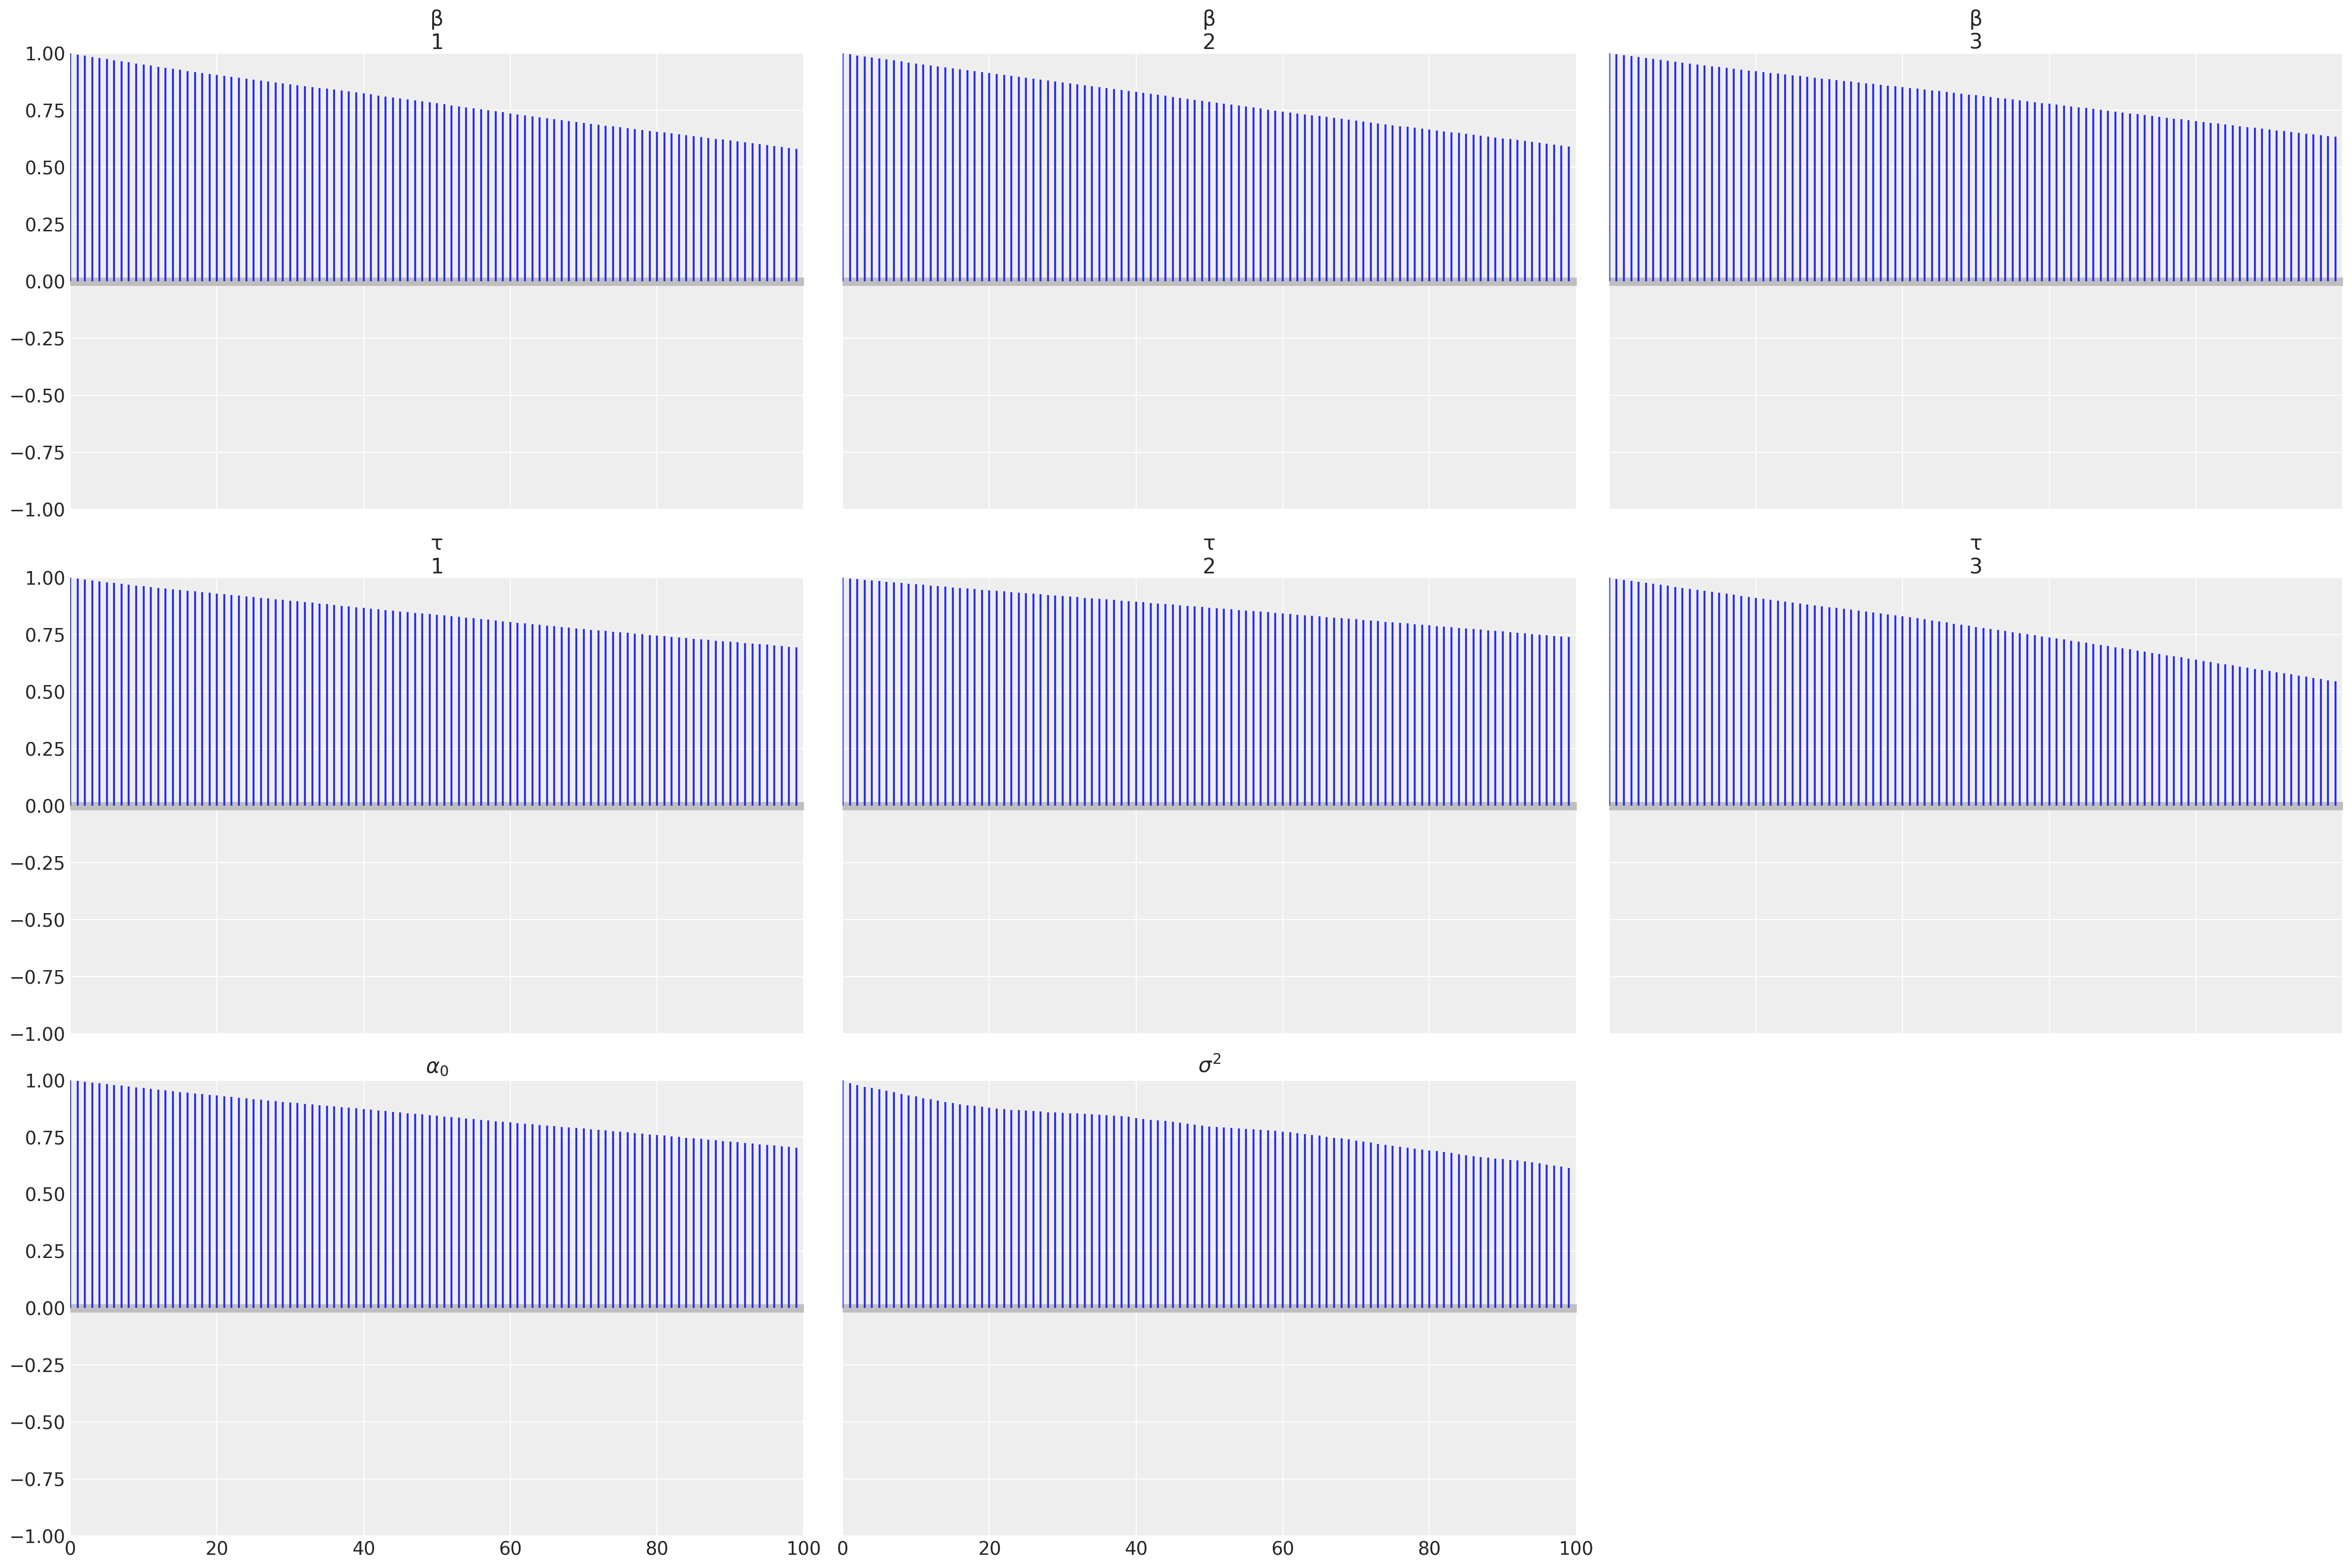

In [34]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

### Out-of-sample predictions

Generating posterior predictive samples...
bpv [T=min]: 0.354
bpv [T=max]: 0.429
bpv [T=median]: 0.908
bpv [T=mean]: 0.673
bpv [T=std]: 0.351


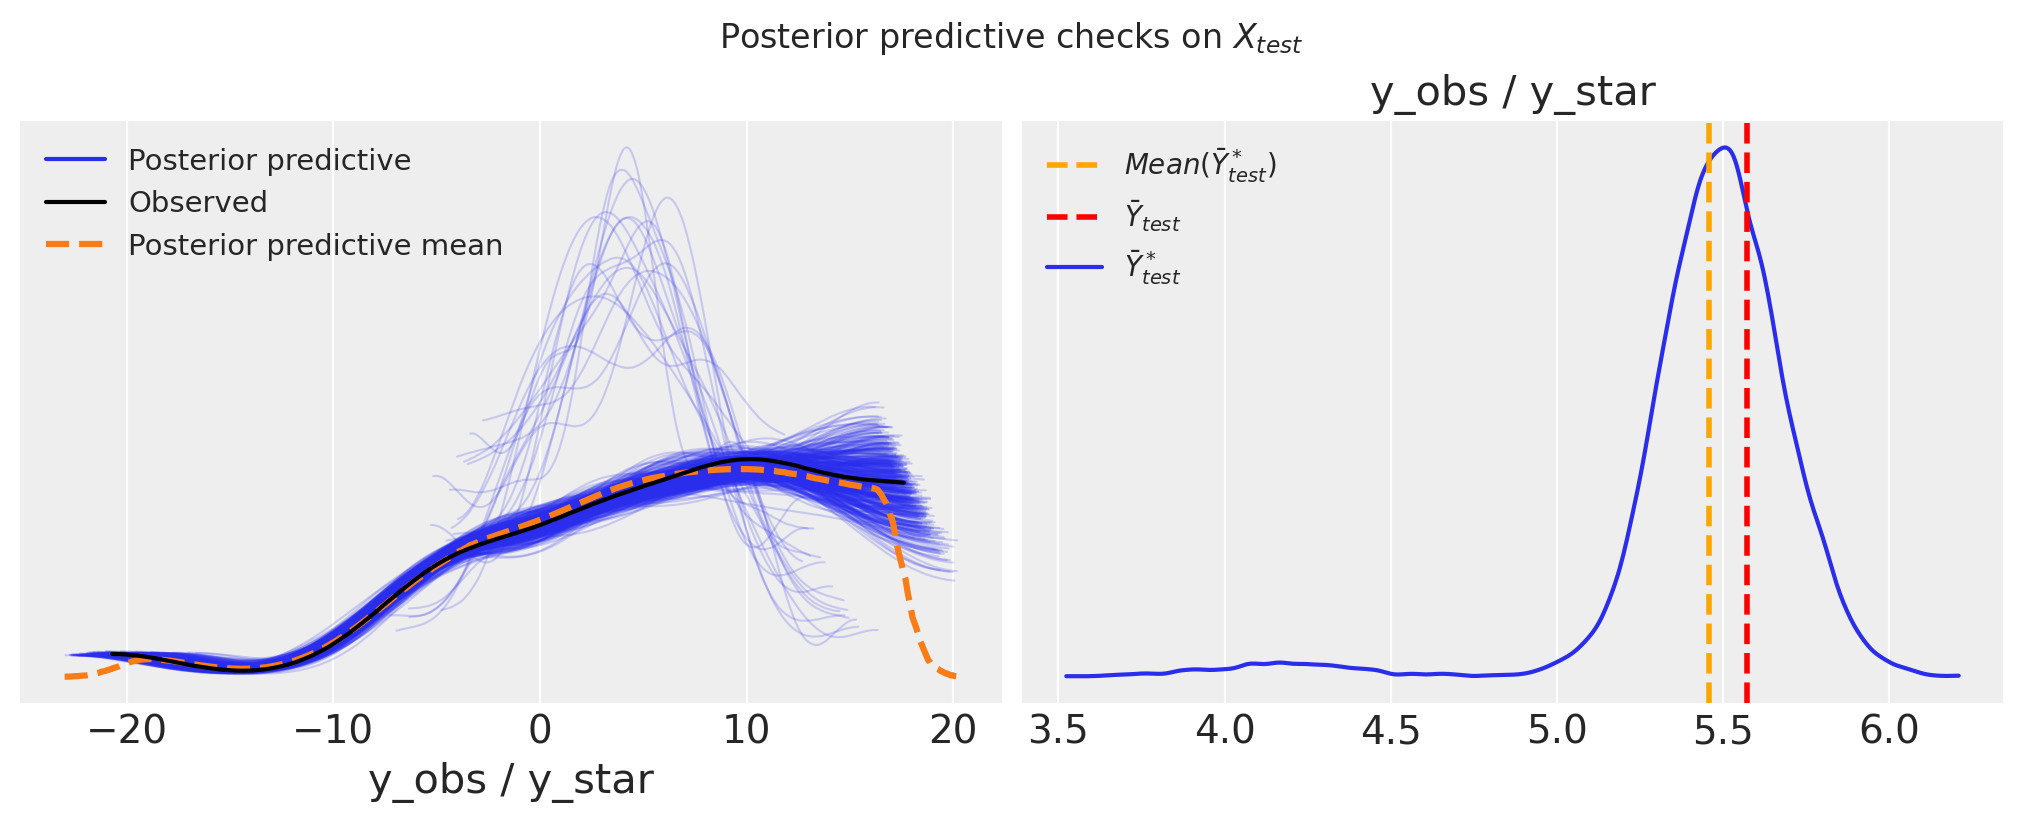

In [44]:
# -- Generate and plot posterior predictive checks from X_test

# Posterior predictive checks
pp_test = bayesian_model.generate_pp(
    idata_emcee,
    X_test,
    theta_space,
    rng=rng,
    kind='linear',
    verbose=True,
)
idata_pp_test = pp_to_idata(
    [pp_test], idata_emcee, ['y_star'], y_obs=Y_test)

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_pp_test, test=True)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

In [36]:
# -- Compute metrics using several point estimates

# Posterior mean estimate
Y_pred_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
df_metrics_emcee = run_utils.linear_regression_metrics(
    Y_test,
    Y_pred_pp,
    reg_emcee.n_components("posterior_mean"),
    "emcee_posterior_mean"
)

# Point estimates
for pe in reg_emcee.default_point_estimates:
    Y_pred_pe = reg_emcee.predict(X_test, strategy=pe)
    df_metrics_emcee = run_utils.linear_regression_metrics(
        Y_test,
        Y_pred_pe,
        reg_emcee.n_components(pe),
        "emcee_" + pe,
        df=df_metrics_emcee,
    )

df_metrics_emcee.style.hide(axis="index")

In [37]:
# -- Test variable selection procedure

df_metrics_emcee_var_sel = None

for pe in reg_emcee.default_point_estimates:
    X_red = reg_emcee.transform(X, pe=pe)
    X_test_red = reg_emcee.transform(X_test, pe=pe)

    df_metrics_emcee_var_sel = run_utils.multiple_linear_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="emcee",
        pe=pe,
        df=df_metrics_emcee_var_sel,
        random_state=SEED
    )

df_metrics_emcee_var_sel.style.hide(axis="index")

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [44]:
# -- Save

with open("emcee-linear.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [45]:
# -- Load

with open("emcee-linear.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

**TODO (v4)**

- Change imports pymc3 -> pymc; theano.tensor -> aesara.tensor
- Try beta = MvNormal
- Try symbolic shape (e.g. tau.shape == p)
- Measure execution times of new pm.sample_posterior_predictive (X should be MutableData (and changed for X_test) for ppc in test set).
- Si beta acaba siendo DensityDist, medir tiempos con y sin parámetros en beta_logp
- Definir adecuadamente los valores iniciales (initval) en p, para que haya al menos uno en cada cadena.
- Añadir random a beta para poder samplear de ella.
- Cambiar start=.. por initvals=... en pm.sample()
- Probar Sequential Monte Carlo
- Probar jax_sampling

In [45]:
from rkbfr.mcmc_sampler import BFLinearPymc
import pymc as pm

In [ ]:
# -- TEST

def f(x):
    return x[0] + x[1]  # not an actual density

with pm.Model() as model:
    custom_dist = pm.DensityDist(
        "custom_dist", 
        logp=f, 
        shape=2, 
        ndim_supp=1
    )
    #trace = pm.sample(500, step=pm.Metropolis())
    
#az.summary(trace)

In [47]:
# -- TEST 2
import aesara.tensor as at
import aesara
def make_model_linear_pymc(
    X,
    y,
    theta_space,
    *,
    b0,
    g,
    eta,
    prior_p=None,
):
    n, N = X.shape
    ts = theta_space
    p_max = theta_space.p_max

    with pm.Model() as model:
        X_pm = pm.MutableData('X_obs', X)

        if ts.include_p:
            p_cat = pm.Categorical(
                'p_cat', 
                p=list(prior_p.values())
            )
            p = pm.Deterministic(ts.names[ts.p_idx], p_cat + 1)
        else:
            p = p_max

        alpha0 = pm.Flat(ts.names[ts.alpha0_idx])

        sigma2 = pm.HalfCauchy(ts.names[ts.sigma2_idx], 0.5)
        sigma = pm.math.sqrt(sigma2)
        log_sigma = pm.math.log(sigma)

        tau_unordered = pm.Uniform(
            ts.names[ts.tau_idx_grouped] + "_unordered", 
            0.0, 
            1.0, 
            shape=p_max,
        )
        
        tau = pm.Deterministic(
            ts.names[ts.tau_idx_grouped],
            at.sort(tau_unordered)
        )
        tau_red = tau[:p]

        idx = np.abs(ts.grid - tau_red[:, np.newaxis]).argmin(1)
        X_tau = X_pm[:, idx]

        G_tau = pm.math.matrix_dot(X_tau.T, X_tau)
        G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
        G_tau_reg = G_tau + eta * \
            at.max(at.nlinalg.eigh(G_tau)[0])*at.eye(p)
        
        def beta_lprior(value, p, log_sigma, sigma2, G_tau_reg):
            b = (value - b0)[:p]
            G_log_det = pm.math.logdet(G_tau_reg)

            return (0.5*G_log_det
                    - p*log_sigma
                    - pm.math.matrix_dot(b.T, G_tau_reg, b)/(2.*g*sigma2))

        beta_unbounded = pm.DensityDist(
            ts.names[ts.beta_idx_grouped] + "_unbounded",
            p,
            log_sigma,
            sigma2, 
            G_tau_reg,
            logp=beta_lprior,
            shape=3
        )

        # Restrict values of beta
        if ts.beta_range is not None:
            beta = pm.Deterministic(
                ts.names[ts.beta_idx_grouped],
                pm.math.clip(
                    beta_unbounded,
                    ts.beta_range[0],
                    ts.beta_range[1]
                )
            )

        else:
            beta = pm.Deterministic(
                ts.names[ts.beta_idx_grouped],
                beta_unbounded
            )
            
        beta_red = beta[:p]
        expected_obs = alpha0 + pm.math.matrix_dot(X_tau, beta_red)

        y_obs = pm.Normal('y_obs', mu=expected_obs, sigma=sigma, observed=y)

    return model

### Experiments

In [46]:
# -- Sampler parameters

n_chains = N_CORES
USE_NUTS = True

if USE_NUTS:
    n_samples = 500
    n_tune = 500
    step_fn = pm.NUTS
    step_kwargs = {"target_accept": 0.8}
else:
    n_samples = 2000
    n_tune = 2000
    step_fn = pm.Metropolis
    step_kwargs = {}

burn = 0
thin = 1
thin_pp = 5

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [48]:
# -- Run sampler

print(f"-- Running pymc sampler with {N_CORES} cores --")

reg_pymc = BFLinearPymc(
    theta_space,
    n_chains,
    n_samples,
    #model_fn=make_model_linear_pymc,
    #model_kwargs={"b0": mle_theta[:p_max], "g": g, "eta": eta},
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    step_fn=step_fn,
    step_kwargs=step_kwargs,
    n_iter_warmup=n_tune,
    thin=thin,
    thin_pp=thin_pp,
    burn=burn,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    random_state=rng  # change to 'SEED' for the same output each time
)

if FAST_RUN:
    df_metrics_pymc = run_utils.run_bayesian_model(
        reg_pymc,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        kind='linear',
        prefix='pymc',
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        verbose=True,
        notebook=True,
        sort_by=sort_by,
        random_state=SEED,
    )
    if COMPUTE_METRICS_FAST_RUN:
        if COMPUTE_MLE:
            df_metrics_pymc = pd.concat([df_metrics_pymc, df_metrics_mle])
        if FIT_SK:
            df_metrics_pymc = pd.concat([df_metrics_pymc, df_metrics_sk])

        df_metrics_pymc.sort_values(
            df_metrics_pymc.columns[sort_by],
            inplace=True
        )
        display(df_metrics_pymc.style.hide(axis="index"))
else:
    reg_pymc.fit(X, Y)
    print(f"Mean acceptance: {100*reg_pymc.mean_acceptance():.3f}%")

idata_pymc = reg_pymc.get_idata()

-- Running pymc sampler with 4 cores --
[BFLinearPymc] Computing MLE...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...


ValueError: Input dimension mismatch. One other input has shape[0] = 3, but input[1].shape[0] = 5.
Apply node that caused the error: Elemwise{sub,no_inplace}(Subtensor{:int8:}.0, TensorConstant{[-0.94  -2..59  9.826]})
Toposort index: 13
Inputs types: [TensorType(float64, (None,)), TensorType(float64, (5,))]
Inputs shapes: [(3,), (5,)]
Inputs strides: [(8,), (8,)]
Inputs values: [array([-0.012,  0.803,  0.638]), array([-0.94 , -2.258, -5.262,  1.459,  9.826])]
Outputs clients: [[CGemv{inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, InplaceDimShuffle{1,0}.0, Elemwise{sub,no_inplace}.0, TensorConstant{0.0}), InplaceDimShuffle{x,0}(Elemwise{sub,no_inplace}.0)]]

Backtrace when the node is created (use Aesara flag traceback__limit=N to make it longer):
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/pymc/model.py", line 1787, in check_start_vals
    initial_eval = self.point_logps(point=elem)
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/pymc/model.py", line 1823, in point_logps
    factor_logps_fn = [at.sum(factor) for factor in self.logp(factors, sum=False)]
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/pymc/model.py", line 753, in logp
    rv_logps = joint_logp(list(rv_values.keys()), rv_values, sum=False, jacobian=jacobian)
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/pymc/distributions/logprob.py", line 235, in joint_logp
    temp_logp_var_dict = factorized_joint_logprob(
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/aeppl/joint_logprob.py", line 147, in factorized_joint_logprob
    q_logprob_vars = _logprob(
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/functools.py", line 888, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/pymc/distributions/distribution.py", line 797, in density_dist_logp
    return logp(value_var, *_dist_params)
  File "/home/antcc/MCD/TFM/rk-bfr/rkbfr/bayesian_model.py", line 807, in beta_lprior
    b = (value - b0)[:p]
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/pymc/model.py", line 1787, in check_start_vals
    initial_eval = self.point_logps(point=elem)
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/pymc/model.py", line 1823, in point_logps
    factor_logps_fn = [at.sum(factor) for factor in self.logp(factors, sum=False)]
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/pymc/model.py", line 753, in logp
    rv_logps = joint_logp(list(rv_values.keys()), rv_values, sum=False, jacobian=jacobian)
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/pymc/distributions/logprob.py", line 235, in joint_logp
    temp_logp_var_dict = factorized_joint_logprob(
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/aeppl/joint_logprob.py", line 147, in factorized_joint_logprob
    q_logprob_vars = _logprob(
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/functools.py", line 888, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/pymc/distributions/distribution.py", line 797, in density_dist_logp
    return logp(value_var, *_dist_params)
  File "/home/antcc/MCD/TFM/rk-bfr/rkbfr/bayesian_model.py", line 807, in beta_lprior
    b = (value - b0)[:p]

HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

In [15]:
# -- Trace summary

reg_pymc.summary(stats='all')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β[1]       -2.729  2.449  -4.798    2.858      1.123    0.849      10.0   
β[2]        9.413  2.068   5.931   13.101      0.965    0.733       5.0   
β[3]       -0.515  1.804  -3.437    3.422      0.814    0.614       5.0   
τ[1]        0.206  0.250   0.095    0.799      0.115    0.087      10.0   
τ[2]        0.800  0.005   0.795    0.805      0.001    0.001      26.0   
τ[3]        0.814  0.026   0.796    0.853      0.008    0.006      14.0   
$\alpha_0$  4.732  0.156   4.476    5.059      0.006    0.005     595.0   
$\sigma^2$  2.180  0.682   1.369    3.680      0.279    0.210      10.0   

            ess_tail  r_hat    min     max  median    mode  
β[1]            12.0   1.32 -5.454   5.244  -3.641  -3.835  
β[2]            12.0   2.53  4.545  13.658   9.763  10.339  
β[3]            12.0   2.21 -4.278   4.233  -0.696  -0.928  
τ[1]            18.0   1.31  0.085   0.804   0.100   0.099  
τ[2]            33.0   1.10  0.795   0.840   0.799   0.795  
τ[3]            14.0   1.20  0.795   0.958   0.805   0.804  
$\alpha_0$     532.0   1.02  4.186   5.301   4.726   4.688  
$\sigma^2$      18.0   1.32  1.267   5.361   1.975   1.855

Combined density and trace plot:


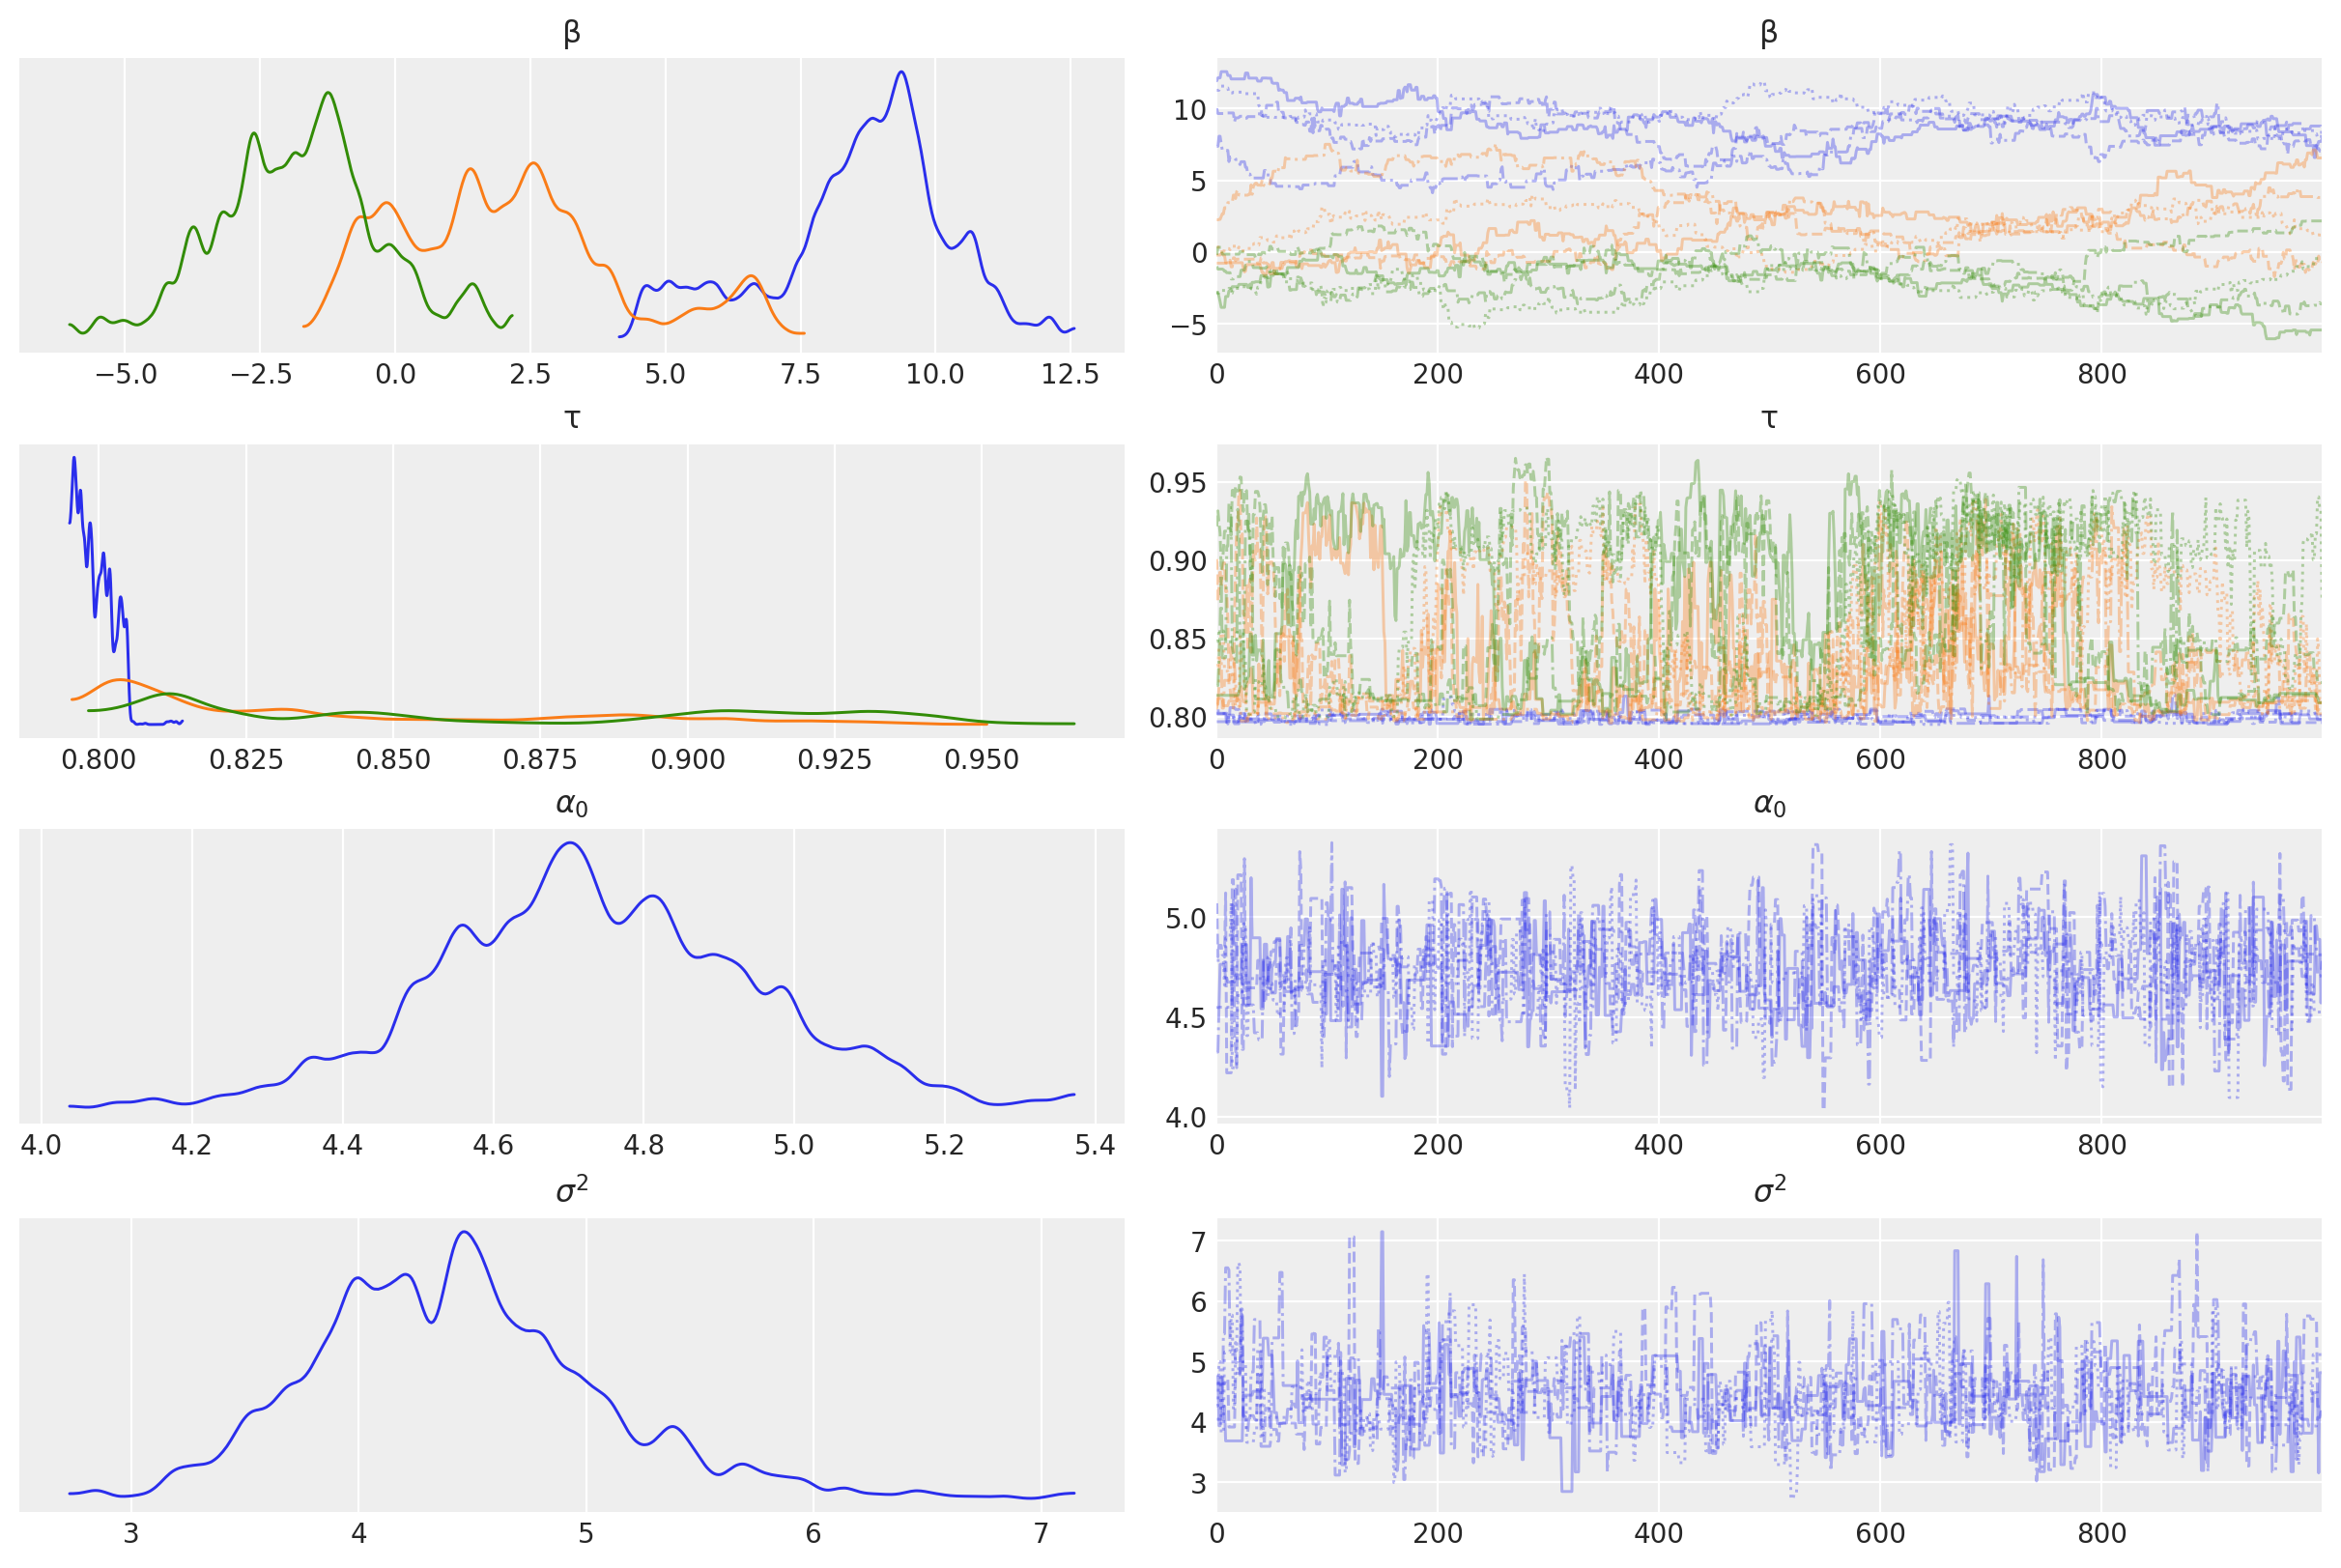

In [37]:
# -- Trace plot

az.plot_trace(
    idata_pymc,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)
print("Combined density and trace plot:")

Marginal posterior distributions:


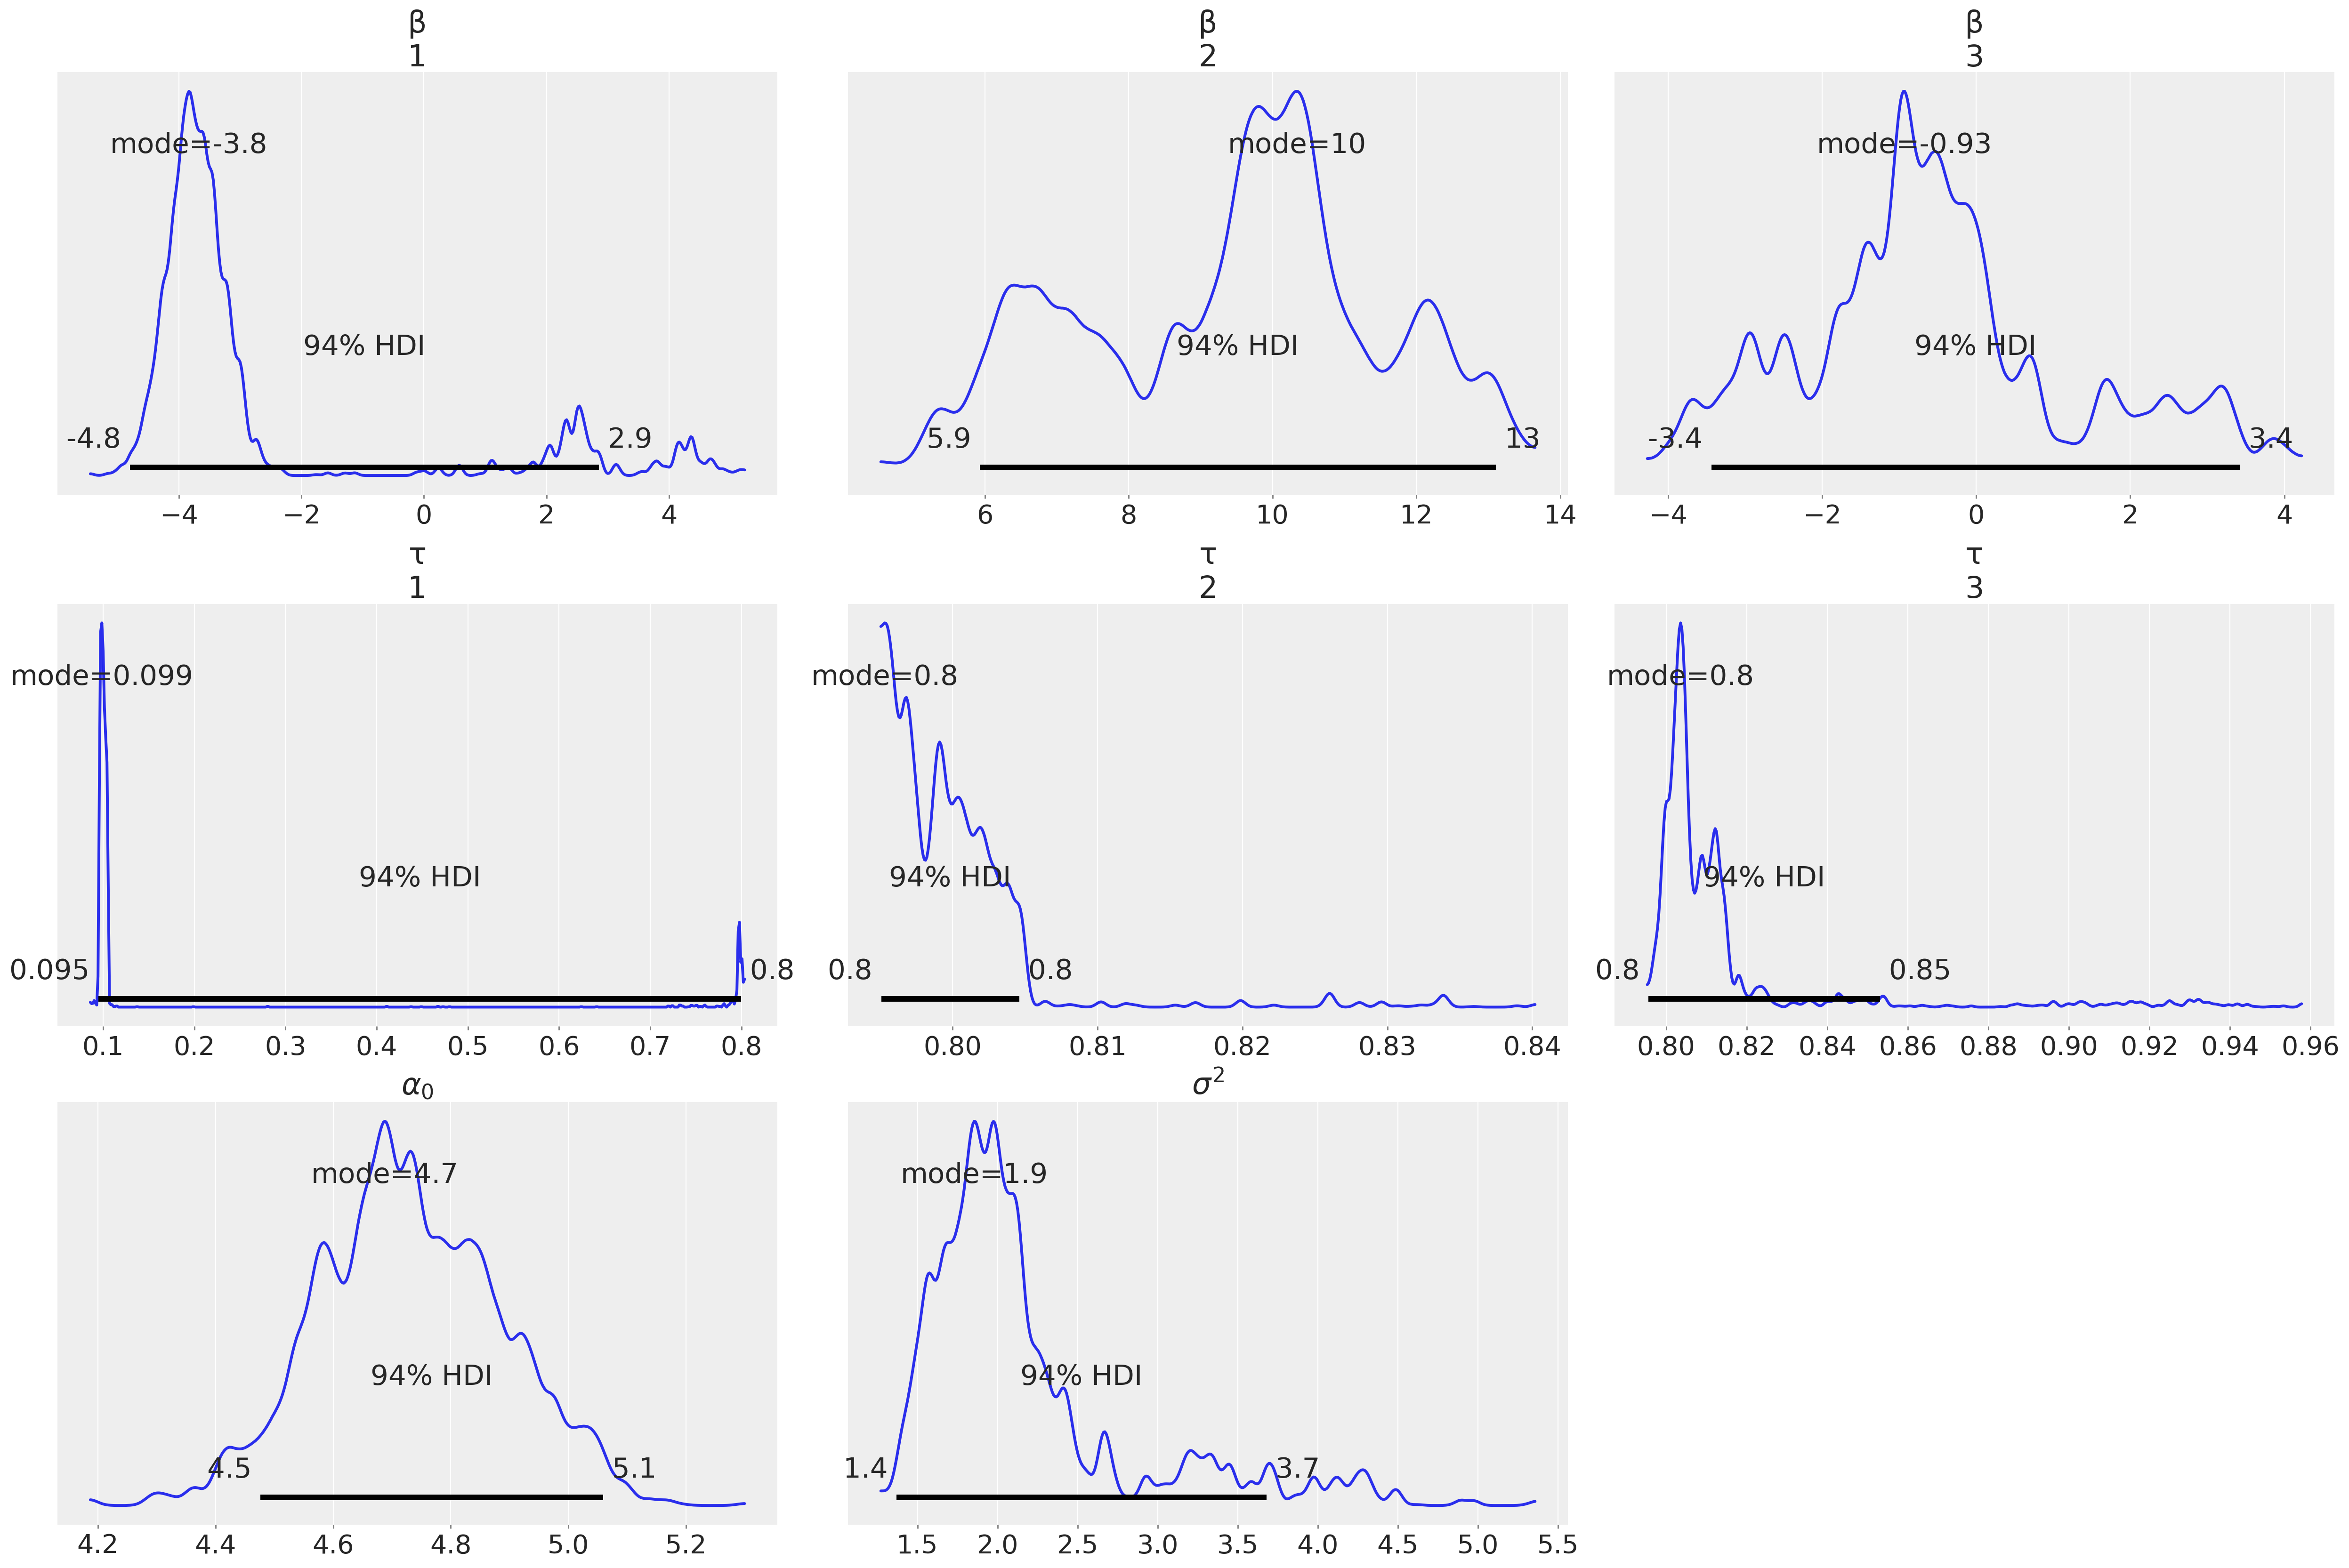

In [17]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

Forest plot of 94% HDI for β and τ:


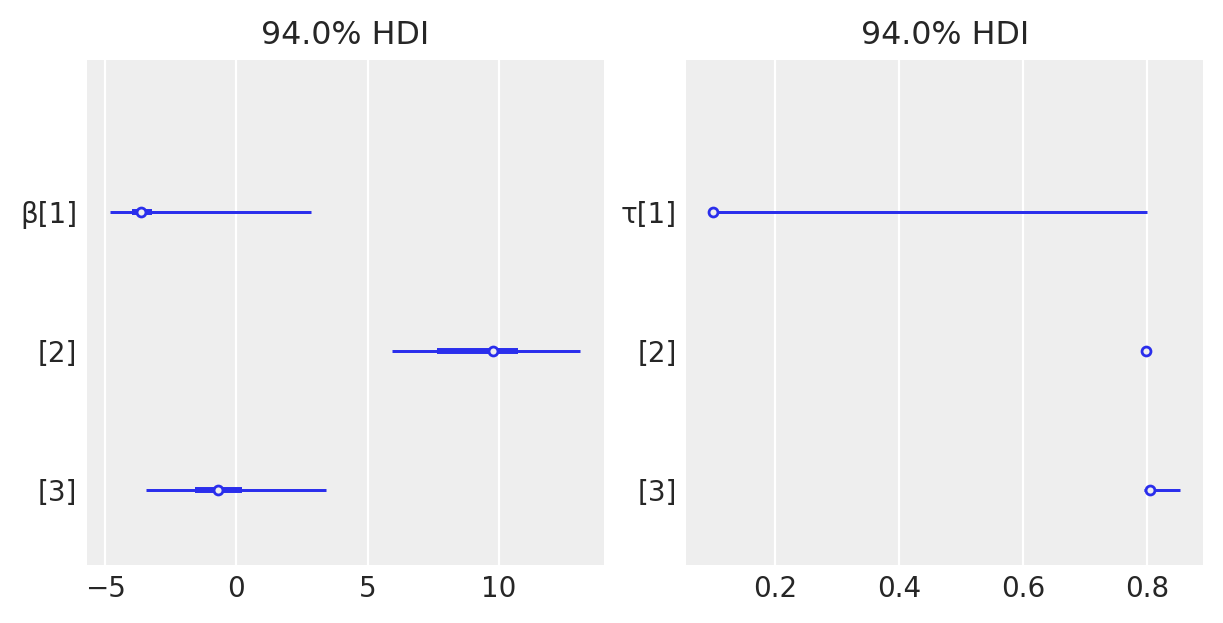

In [18]:
# -- Forest plot

plot_utils.plot_forest(
    idata_pymc, 
    theta_space, 
    textsize=10, 
    var_names=[theta_names[theta_space.beta_idx_grouped], 
               theta_names[theta_space.tau_idx_grouped]]
)

print("Forest plot of 94% HDI for β and τ:")

Generating posterior predictive samples...
bpv [T=min]: 0.114
bpv [T=max]: 0.522
bpv [T=median]: 0.516
bpv [T=mean]: 0.517
bpv [T=std]: 0.957


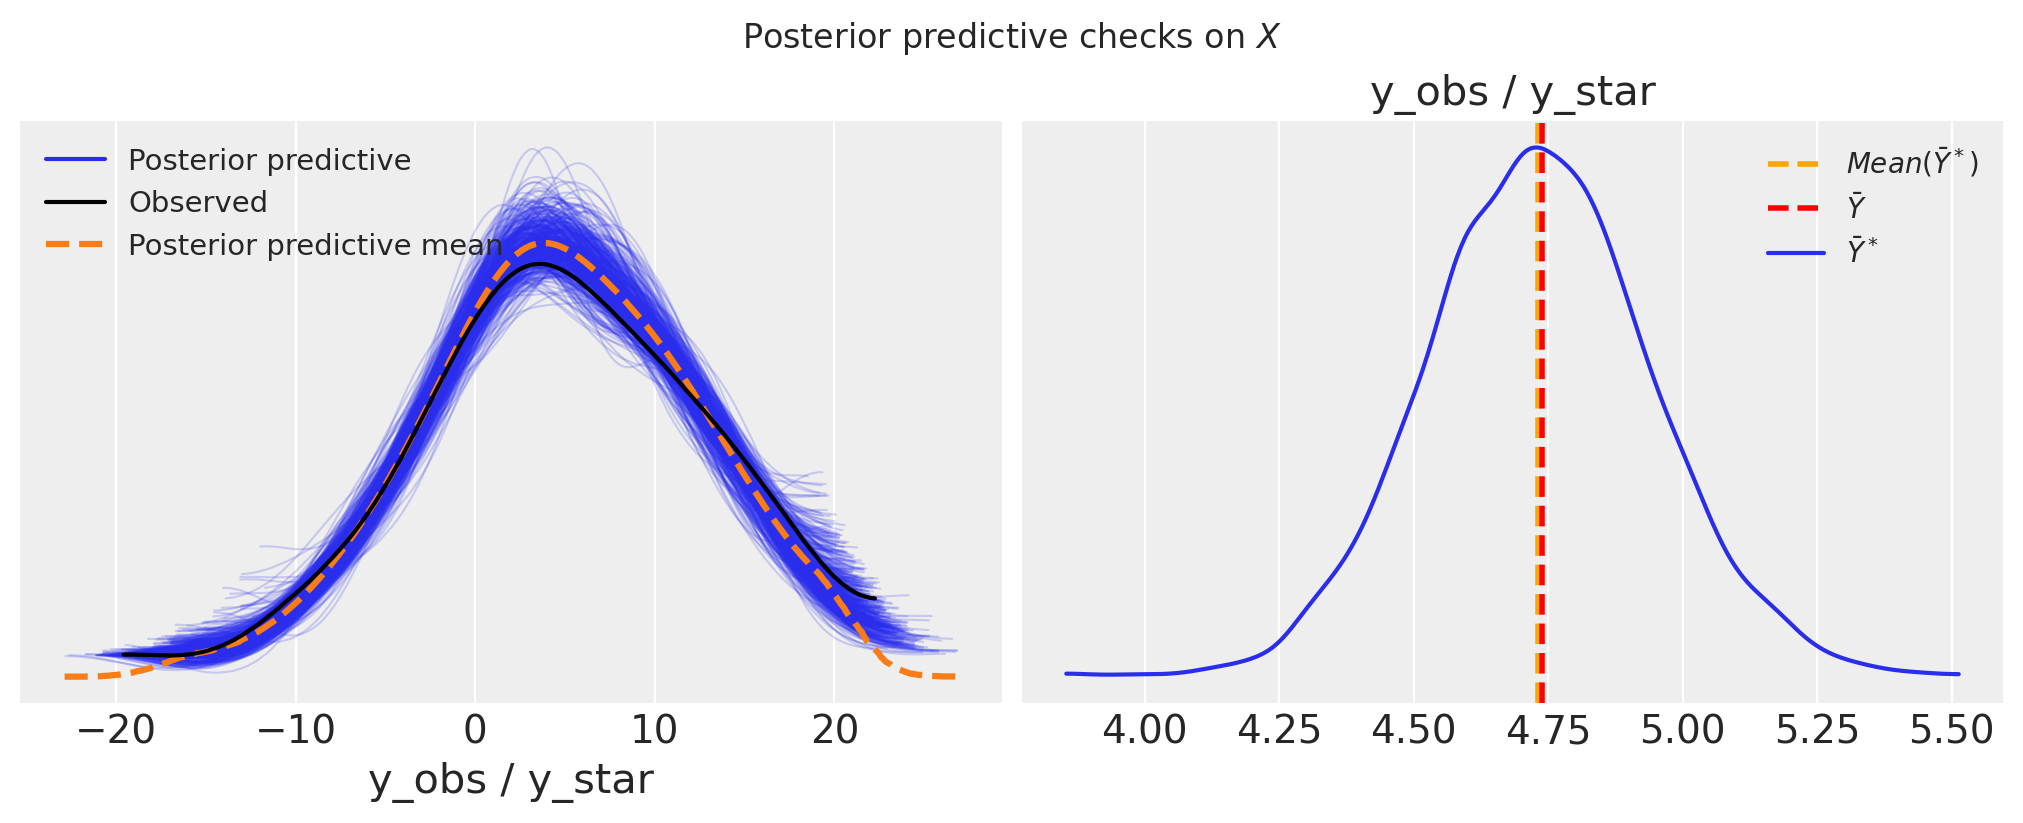

In [19]:
# -- Generate and plot posterior predictive checks from X

pp = bayesian_model.generate_pp(
    idata_pymc, X, theta_space,
    rng=rng, kind='linear', verbose=True)
pp_to_idata([pp], idata_pymc, ['y_star'], merge=True)

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_pymc, test=False)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


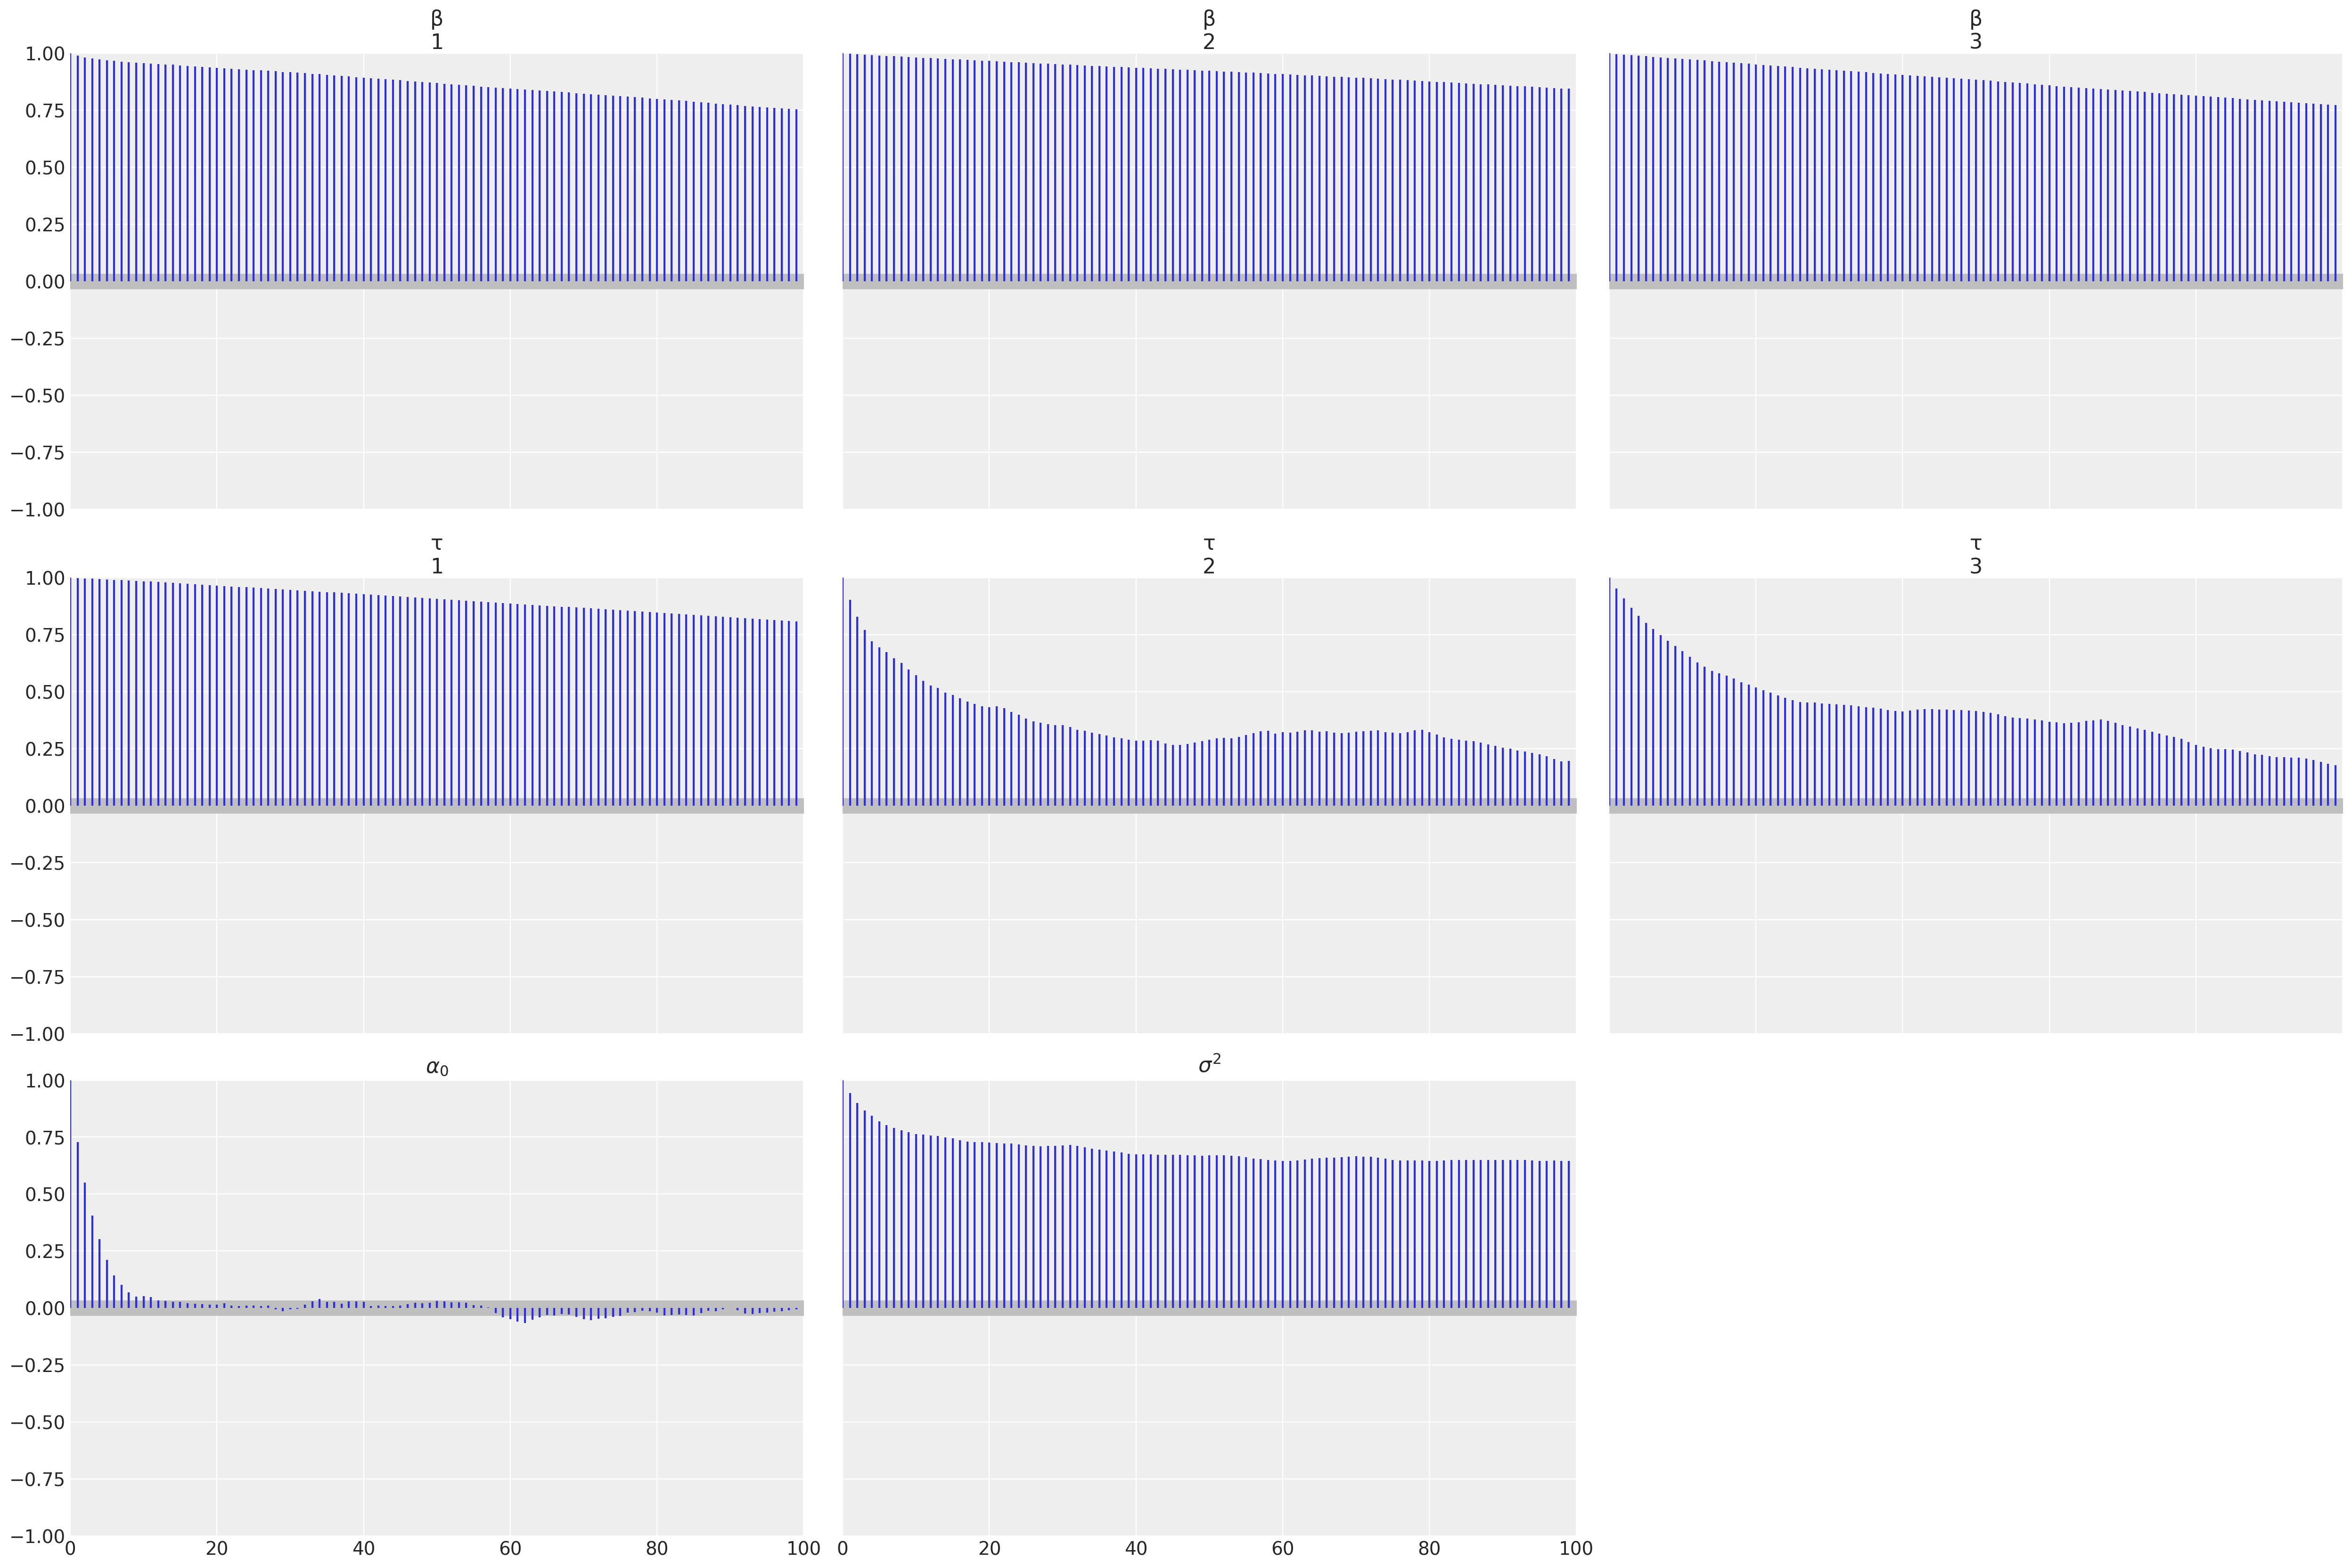

In [20]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

Graphical model:


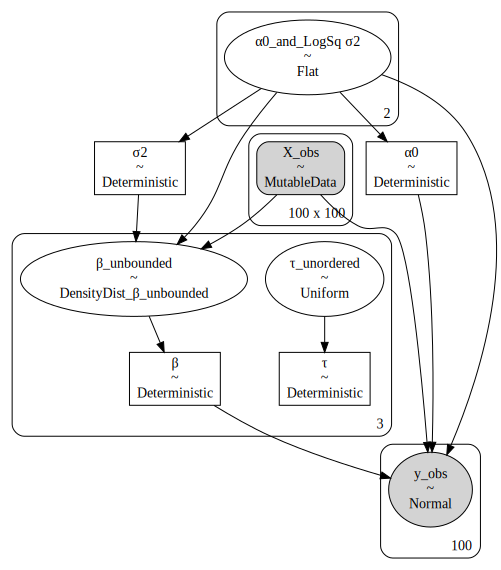

In [22]:
# -- Graphical model

print("Graphical model:")
reg_pymc.to_graphviz()

### Out-of-sample predictions

First we take a look at the distribution of predictions on a previously unseen dataset.

Generating posterior predictive samples...
bpv [T=min]: 0.194
bpv [T=max]: 0.770
bpv [T=median]: 0.475
bpv [T=mean]: 0.624
bpv [T=std]: 0.903


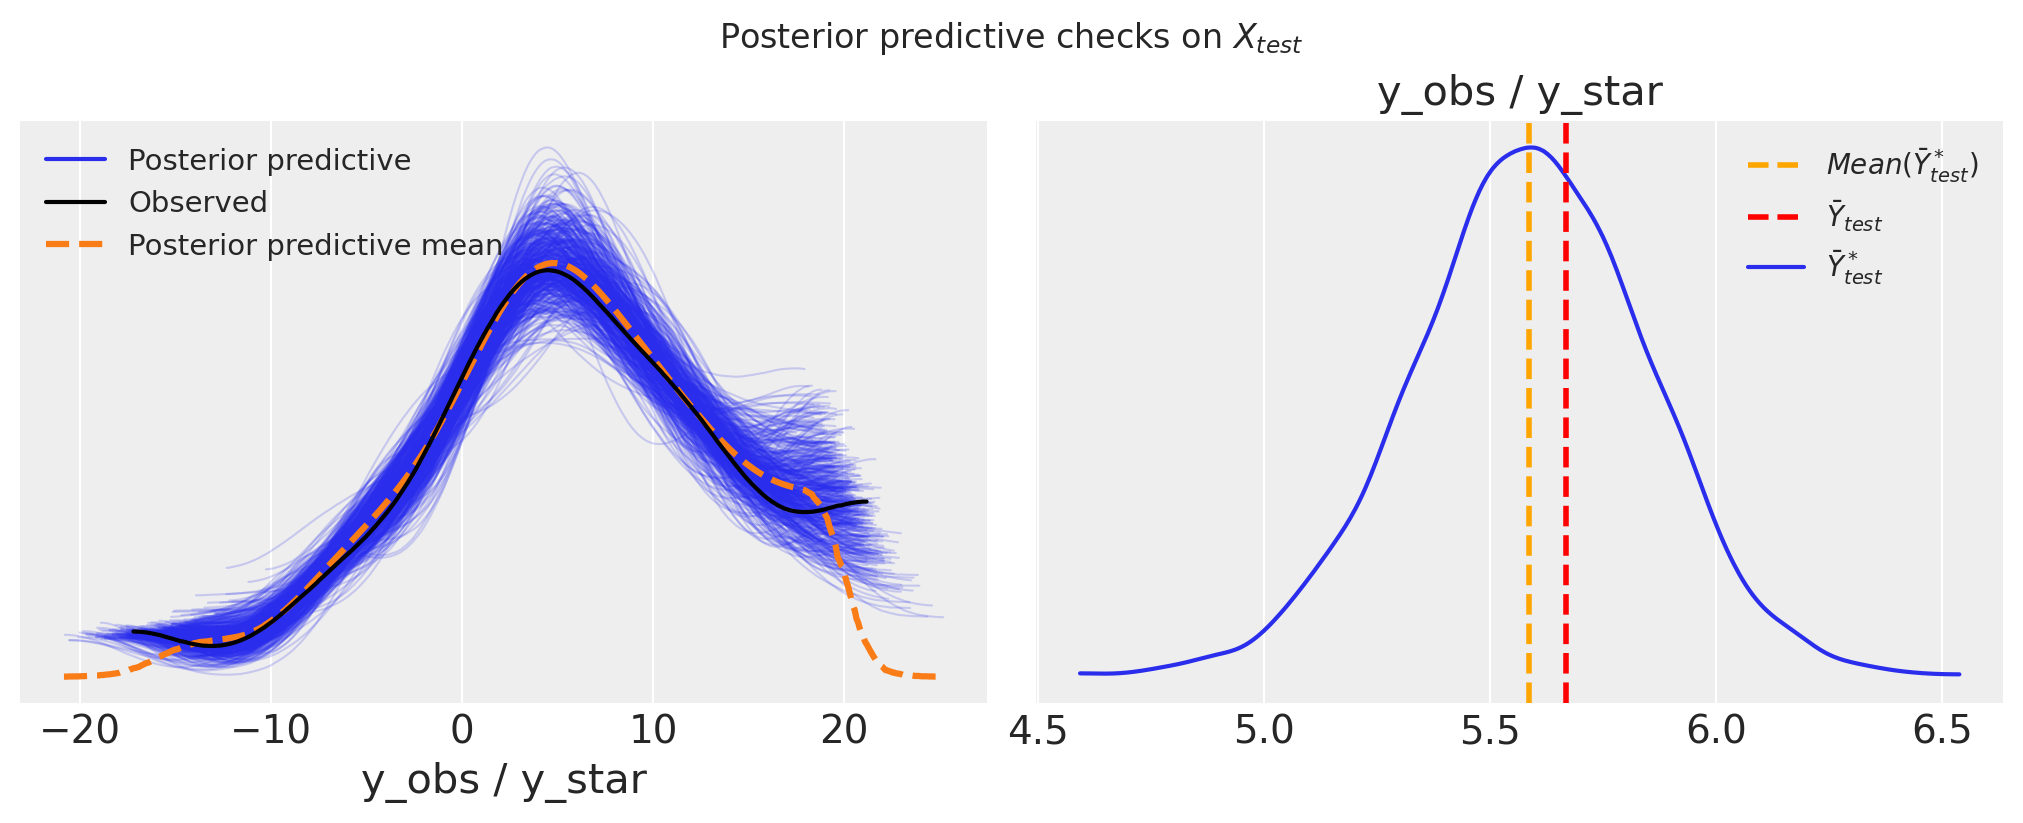

In [23]:
# -- Generate and plot posterior predictive checks from X_test

pp_test = bayesian_model.generate_pp(
    idata_pymc, X_test, theta_space,
    rng=rng, kind='linear', verbose=True)
idata_pp_test = pp_to_idata(
    [pp_test], idata_pymc, ['y_star'], y_obs=Y_test)

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_pp_test, test=True)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Next we look at the MSE when using several point-estimates for the parameters, as well as the mean of the posterior samples.

In [24]:
# -- Compute metrics using several point estimates

# Posterior mean estimate
Y_pred_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
df_metrics_pymc = run_utils.linear_regression_metrics(
    Y_test,
    Y_pred_pp,
    reg_pymc.n_components("posterior_mean"),
    "pymc_posterior_mean"
)

# Point estimates
for pe in reg_pymc.default_point_estimates:
    Y_pred_pe = reg_pymc.predict(X_test, strategy=pe)
    df_metrics_pymc = run_utils.linear_regression_metrics(
        Y_test,
        Y_pred_pe,
        reg_pymc.n_components(pe),
        "pymc_" + pe,
        df=df_metrics_pymc,
    )

df_metrics_pymc.style.hide(axis="index")

In [25]:
# -- Test variable selection procedure

df_metrics_pymc_var_sel = None

for pe in reg_pymc.default_point_estimates:
    X_red = reg_pymc.transform(X, pe=pe)
    X_test_red = reg_pymc.transform(X_test, pe=pe)

    df_metrics_pymc_var_sel = run_utils.multiple_linear_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="pymc",
        pe=pe,
        df=df_metrics_pymc_var_sel,
        random_state=SEED,
    )

df_metrics_pymc_var_sel.style.hide(axis="index")

### Save & Load

In [42]:
# -- Save

_ = idata_pymc.to_netcdf("pymc-linear.nc")

In [43]:
# -- Load

idata_pymc = az.from_netcdf("pymc-linear.nc")

## Notebook metadata

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Jun 03 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.30.1

arviz     : 0.12.1
skfda     : 0.0
numpy     : 1.22.1
pandas    : 1.4.2
emcee     : 3.1.2
autopep8  : 1.6.0
pymc3     : 3.11.5
json      : 2.0.9
matplotlib: 3.5.2
sys       : 3.9.13 (main, May 19 2022, 08:22:48) 
[GCC 12.1.0]

Watermark: 2.2.0

